# Business Case
## A Rossmann opera mais de 3.000 drogarias em 7 países europeus. Atualmente, os gerentes de loja da Rossmann têm a tarefa de prever suas vendas diárias com até 6 semanas de antecedência. As vendas da loja são influenciadas por muitos fatores, incluindo promoções, competição, feriados escolares e estaduais, sazonalidade e localidade. Com milhares de gerentes prevendo vendas com base em suas circunstâncias únicas, a precisão dos resultados pode ser bastante variada. Devido a isto, há uma necessidade da utilização de modelos de Machine Learning para obter resultados com uma maior assertividade.

## O Objetivo é realizar a previsão das vendas de até 6 semanas utilizando Machine Learning.

# 0.0. Imports

In [1]:
import math
import json
import pickle
import random
import warnings
import datetime
import requests
import inflection
import numpy   as np
import pandas  as pd
import seaborn as sns
import xgboost as xgb

from scipy                 import stats as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt

from IPython.display       import Image
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from IPython.core.display  import HTML
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
warnings.filterwarnings( 'ignore' )

## 0.1. Funções

In [2]:
# Função para calcular a validação cruzada dos modelos
def cross_validation( x_training, kfold, model_name, model, verbose=False):
    # Inicio das variaveis listas para armazenar os valores das métricas
    mae_list = []
    mape_list = []
    rmse_list = []

    # Loop de iteração para rodar cada KFOLD
    for k in reversed( range( 1, kfold+1 ) ):
        
        # Print do KFOLD em execução
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
            
        # Data inicial e final para validação
        validation_start_date = x_training['date'].max() - datetime.timedelta( days = k*6*7 )
        validation_end_date = x_training['date'].max() - datetime.timedelta( days = (k-1)*6*7 )

        # Fil
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        # Datasets de treino e validação
        # Treino
        xtraining = training.drop( ['date','sales'], axis=1 )
        ytraining = training['sales']

        # Validação
        xvalidation = validation.drop( ['date','sales'], axis=1 )
        yvalidation = validation['sales']

        # Modelo
        m = model.fit( xtraining, ytraining )

        # Predição
        yhat = m.predict( xvalidation )

        # Performance 
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # Armazenando a performance para cada iteração KFOLD
        mae_list.append( m_result['Mae'] )
        mape_list.append( m_result['Mape'] )
        rmse_list.append( m_result['RMSE'] )

    # Retorna um dataframe com a média e desvio padrão das 5 iterações do KFOLD
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ),2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ),2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ),2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ),2 ).astype( str ) }, index = [0] )

# Função para calculo da porcentagem da raiz do erro médio qudratico
def root_mean_square_percentage_error( y, yhat ):
    rmspe = np.sqrt( np.mean( np.square( ( ( y - yhat ) / y ) ), axis=0 ) )
    return rmspe

# Função para calculo da porcentagem do erro médio
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y ) 

# Função para calculo da porcentagem do erro médio absoluto
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

# Função que retorna todos os erros calculados
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( {'Model Name': model_name,
                          'Mae': mae,
                          'Mape': mape,
                          'RMSE': rmse}, index=[0] )

# Função para definir algumas configurações de graficos
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [30, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Carregando os dados

In [4]:
# Carregamento dos dados
df_sales_raw = pd.read_csv('data/train.csv', low_memory = False)
df_store_raw = pd.read_csv('data/store.csv', low_memory = False)

# Merge dados sales e store
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. PASSO 01 - DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
# Renomeando as colunas para snakecase (separadas por _)
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2. Dimensões dos dados

In [7]:
print('Numero de Linhas: {}'.format(df1.shape[0]))
print('Numero de Colunas: {}'.format(df1.shape[1]))

Numero de Linhas: 1017209
Numero de Colunas: 18


## 1.3. Tipos dos dados

In [8]:
# Mudando date para data
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Verificação de NA's

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenchendo NA's
### Nessa etapa as linhas que possuem NA estão sendo preenchidas com informações do próprio dataset

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
# Competition_distance, nesse a lógica é de colocar todos os competidores que não temos dados de distancia, em uma distancia padrão de 200000, para não exclui-los da base de dados
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# Competition_open_since_month, para todos os competidores que não sabemos a data de abertura, colocamos o mês base do dataset    
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

# Competition_open_since_year, para todos os competidores que não sabemos o ano de abertura, colocamos o ano base do dataset
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# Promo2_since_week, para todas as promoções que não temos a semana, colocamos a semana base do dataset
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

# Promo2_since_year, para todas as promoções que não temos o ano, colocamos o ano base do dataset 
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# Promo_interval, preenchendo todos os NA com 0
df1['promo_interval'].fillna(0, inplace=True)

# Dicionario com os meses
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# Criando coluna com o dicionario acima
df1['month_map'] = df1['date'].dt.month.map( month_map )

# Criando coluna binaria se é promoção ou não
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )


In [12]:
# Após a étapa acima, o dataset não possui mais NA's
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Mudando os tipos de dados

In [13]:
# Mudando tipos das variaveis para o adequado
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

In [14]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Estatistica descritiva

In [15]:
# Separando datasets entre numéricos e categóricos
# Numéricos
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
# Categóricos
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [16]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
525083,704,2,12526,1262,1,1,0,1910.0,4,2009,0,12,2014,0
676635,616,6,7445,721,1,0,0,3040.0,8,2011,1,35,2010,0


## 1.7.1 Variaveis numericas

In [17]:
# Tendencias central - média, mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply(lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply(lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply(lambda x: x.kurtosis() ) ).T

# Concatenando todas as estatisticas criadas
m = pd.concat( [d2,d3,d4,ct1,ct2,d1,d5,d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


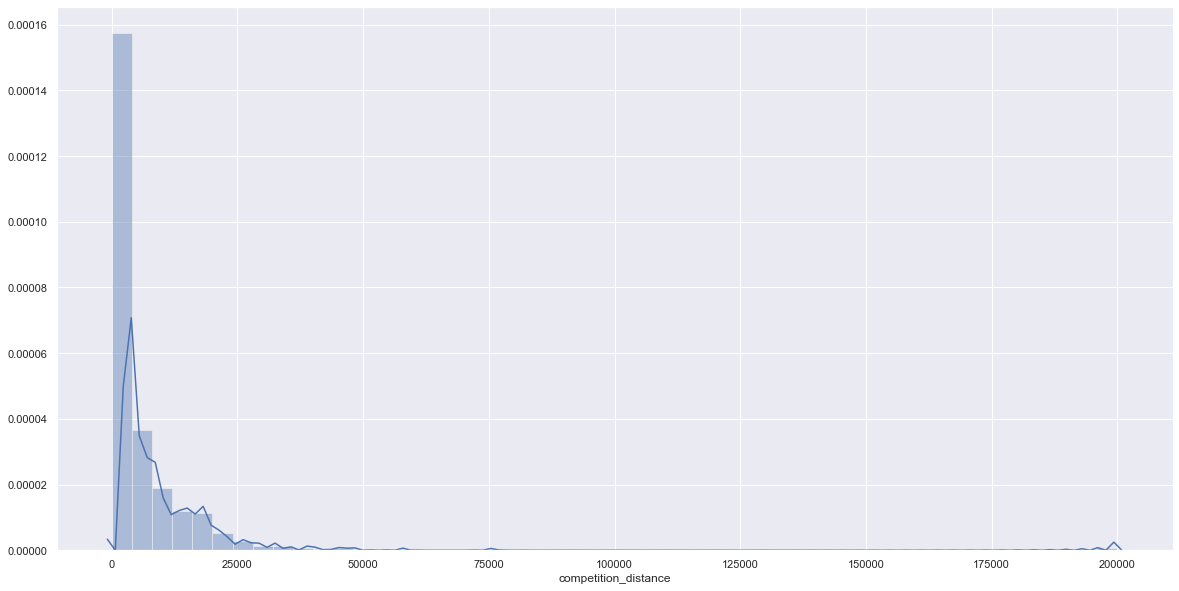

In [18]:
# Plot da coluna competition distance para analisar sua distribuição
plt.figure(figsize=(20,10))
sns.distplot( df1['competition_distance'] )


## 1.7.2 Variaveis categóricas

In [19]:
# Analise dos dados categóricos e valores unicos
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

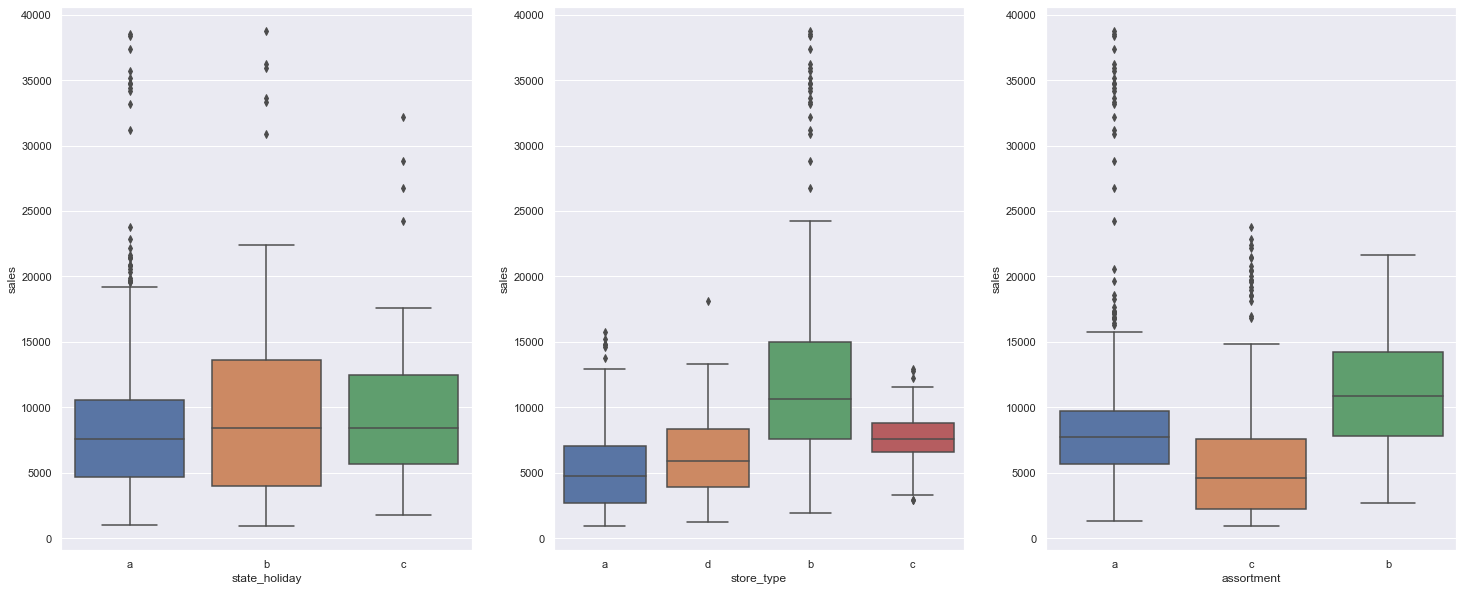

In [20]:
plt.figure(figsize=(25,10))
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0 )]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1 )

# 2.0. PASSO 02 - FEATURE ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipoteses
### A idéia desse mapa é ter uma visão do negócio e dos seus respectivos atributos, para assim criar hipóteses para serem validadas/refutadas com análises

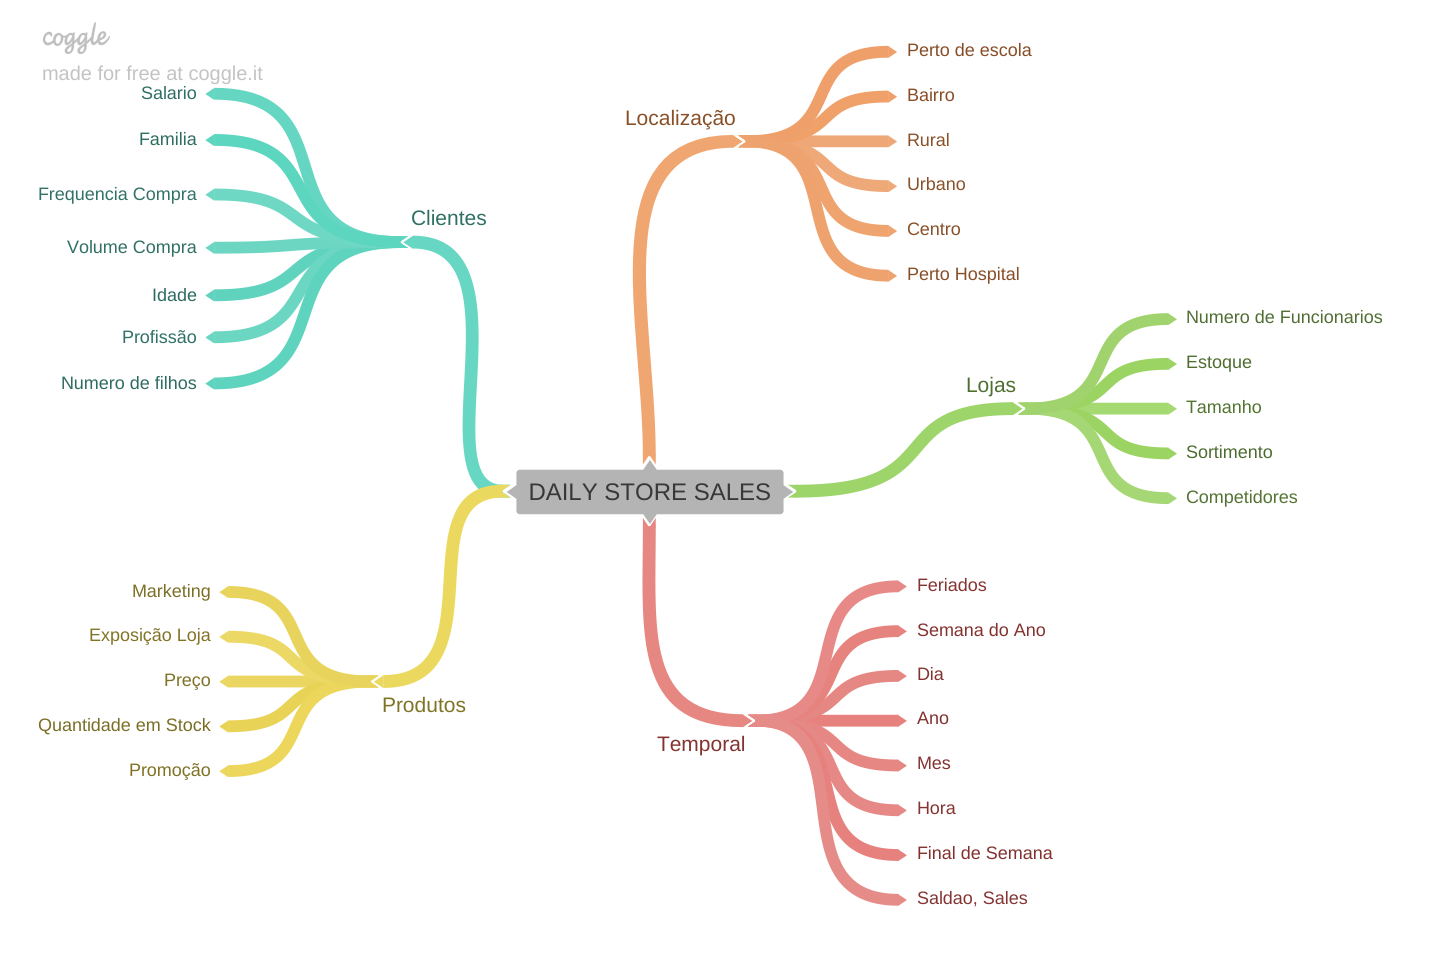

In [22]:
Image( 'img/MindMapHypothesis.png' )

## 2.2 Criação das Hipoteses

### 2.2.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4. Feature Engineering
### Criação de algumas variaveis para serem utilizadas nas análises

In [23]:
# Ano
df2['year'] = df2['date'].dt.year

# Mês
df2['month'] = df2['date'].dt.month

# Dia
df2['day'] = df2['date'].dt.day

# Semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

# Ano e semana
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# Ano, mês e dia da abertura da loja de competidores
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )

# Tempo de abertura em dias dos competidores
df2['competition_time_month'] = ( ( df2['date'] -df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype(np.int64)

# Concatenando ano e semana de promoçao
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# Tempo de promoção por semana
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( np.int64 )

# Atribuindo os nomes corretos para os valores categóricos
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended'  )

# Atribuindo os nomes corretos para os valores categóricos
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'  )



In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [25]:
df3 = df2.copy()

In [26]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

In [27]:
# Filtrando somente lojas abertas e com vendas maior que 0
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Seleção das Colunas

In [28]:
# Dropando colunas que não serão utilizadas
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis = 1 )

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - ANALISE EXPLORATORIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1. Analise Univariada
### Análise individual de cada variavel

### 4.1.1. Variavel resposta

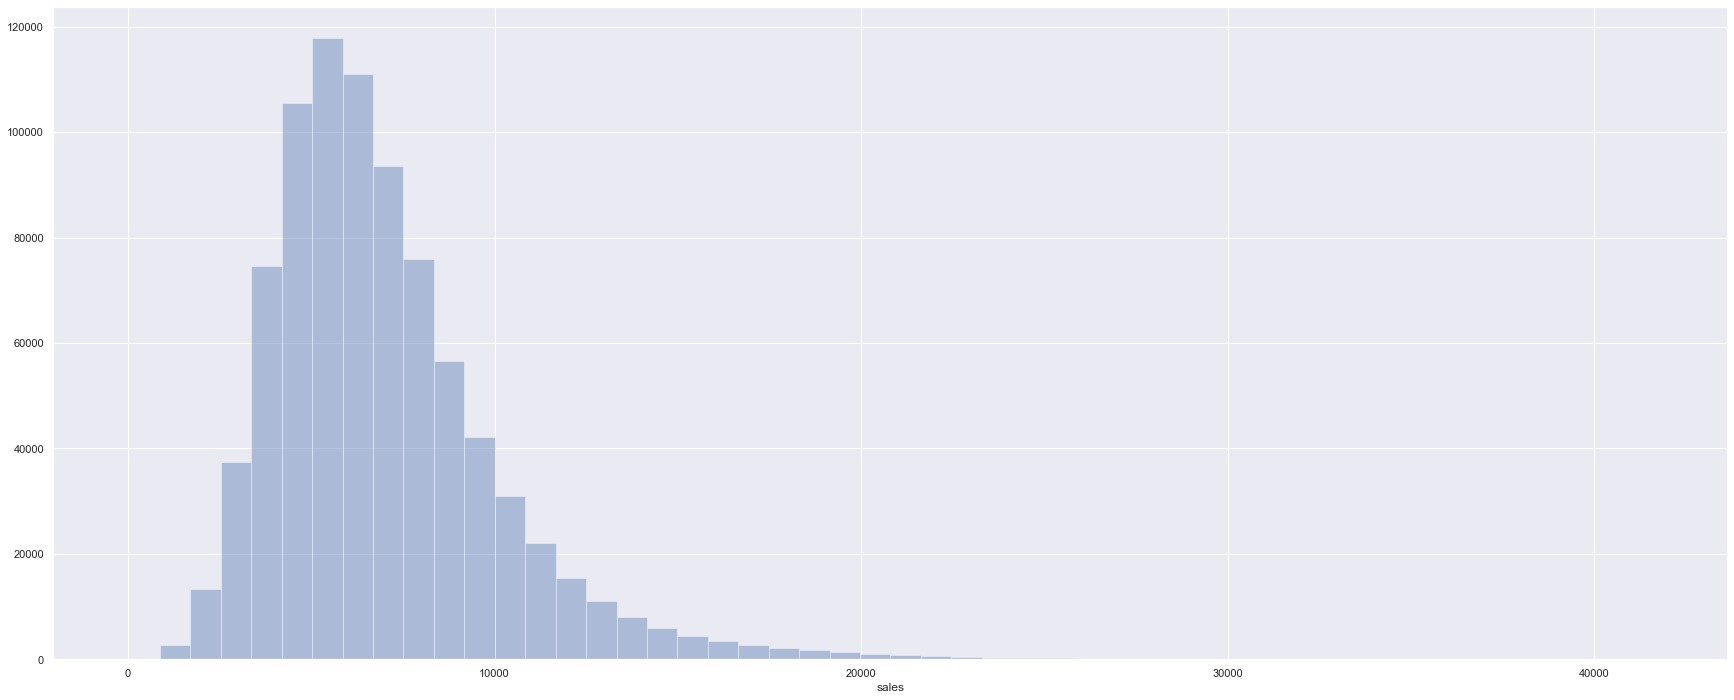

In [31]:
# Análise de distribuição da variavel resposta
sns.distplot( df4['sales'], kde=False ) 

### 4.1.2. Variaveis numericas

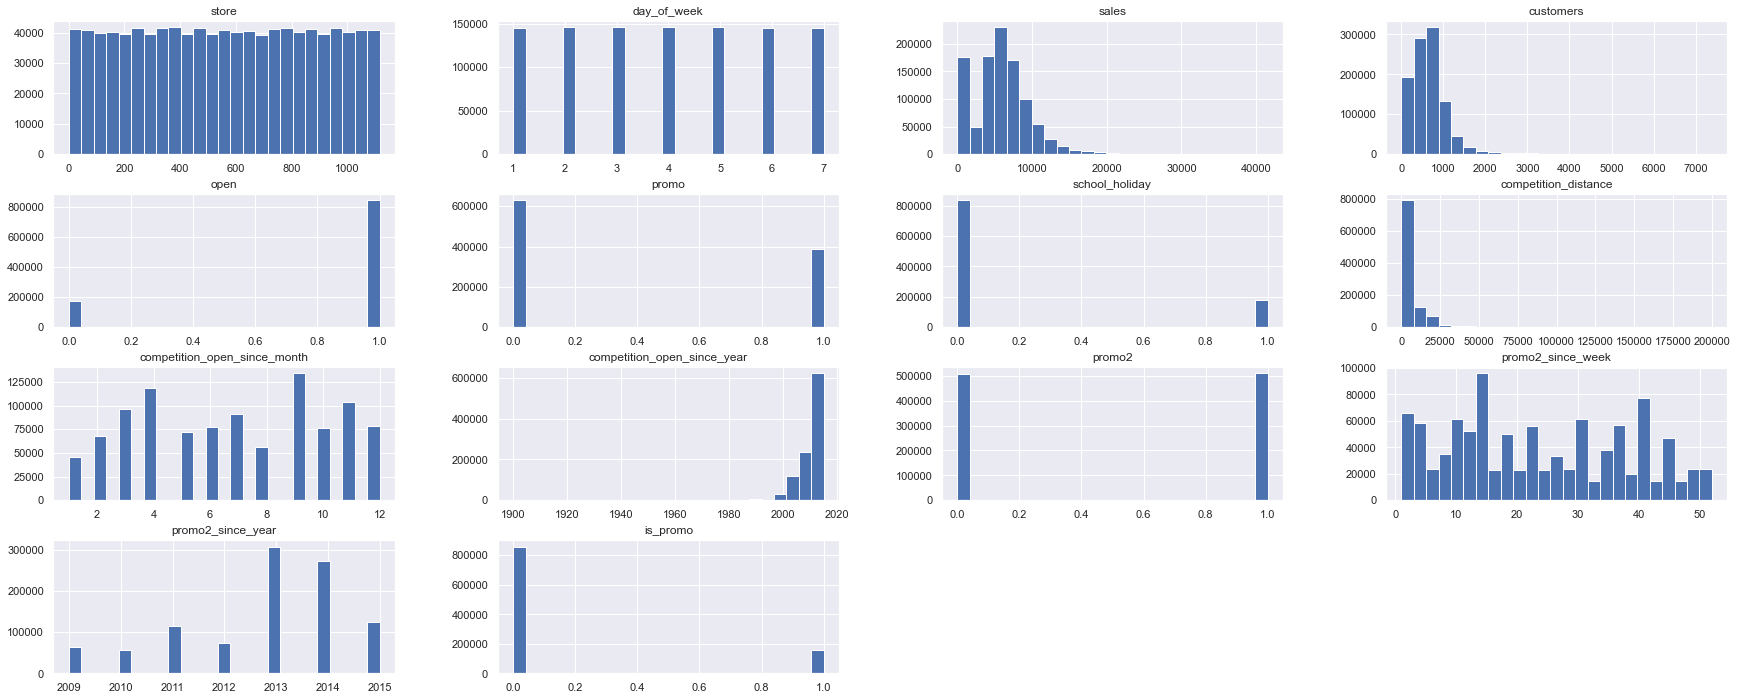

In [32]:
# Análises de frequencia/distribuição das variaveis numericas
num_attributes.hist( bins=25 );

### 4.1.3. Variaveis categóricas

In [33]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

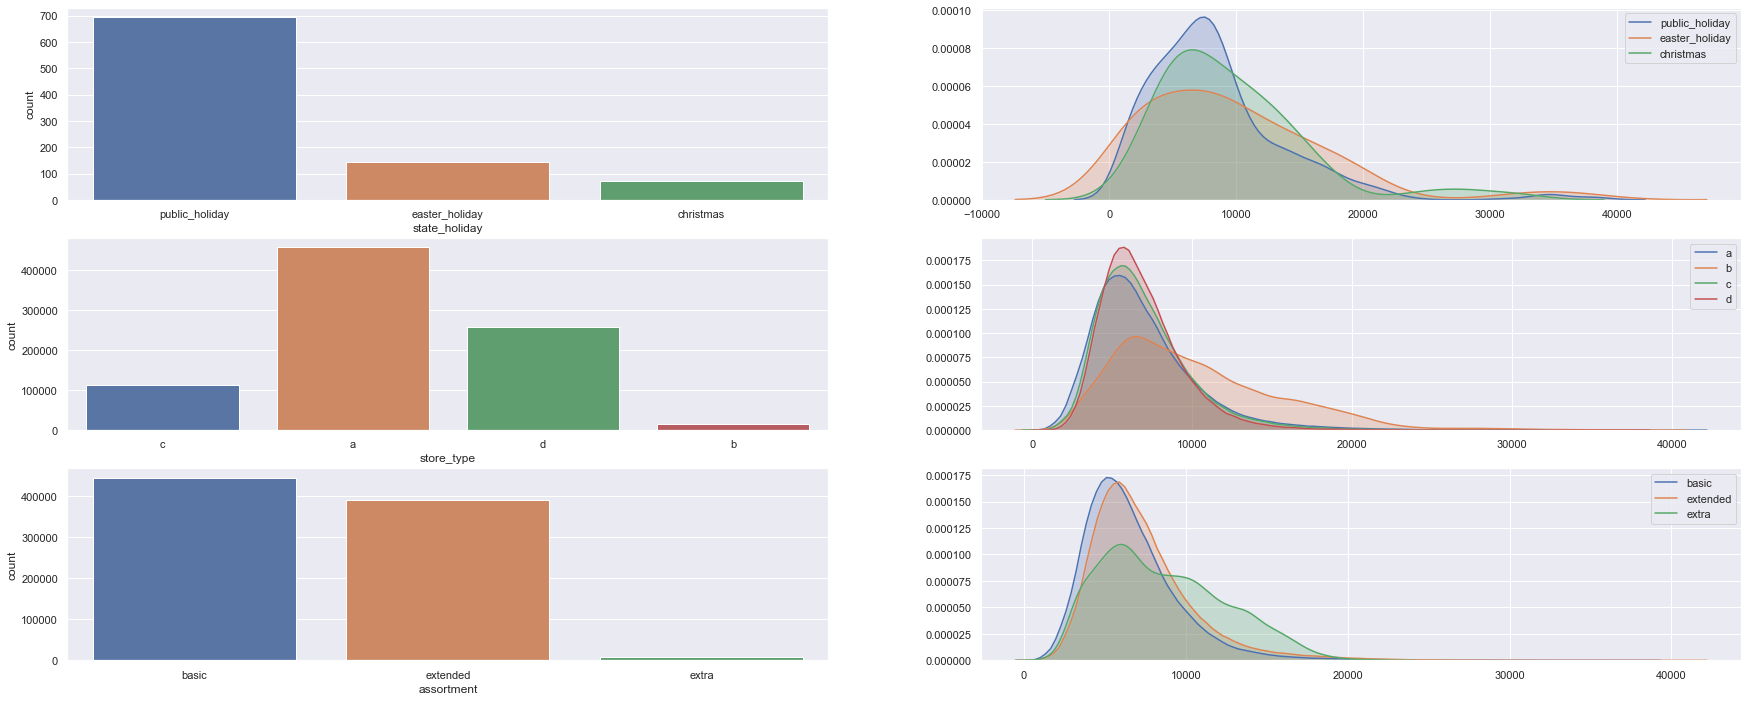

In [34]:
# Analise da variavel state_holiday em função da variavel resposta para cada categoria
plt.subplot( 3, 2, 1 )
# Remoção da categoria regular_day devido distorção dos resultados, visto que a maioria dos dias são regulares
a = df4[df4['state_holiday'] != 'regular_day'] 
sns.countplot( a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday' , shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday' , shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas' , shade=True )


# Analise da variavel store_type em função da variavel resposta para cada categoria
plt.subplot( 3, 2, 3 )
sns.countplot( df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a' , shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b' , shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c' , shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d' , shade=True )


# Analise da variavel assortment em função da variavel resposta para cada categoria
plt.subplot( 3, 2, 5 )
sns.countplot( df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic' , shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended' , shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra' , shade=True )



## 4.1. Analise Bivariada
### Análise das variaveis em função da variavel resposta
Obs: Desse ponto para baixo, algumas hipóteses levantadas são validadas/refutadas

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

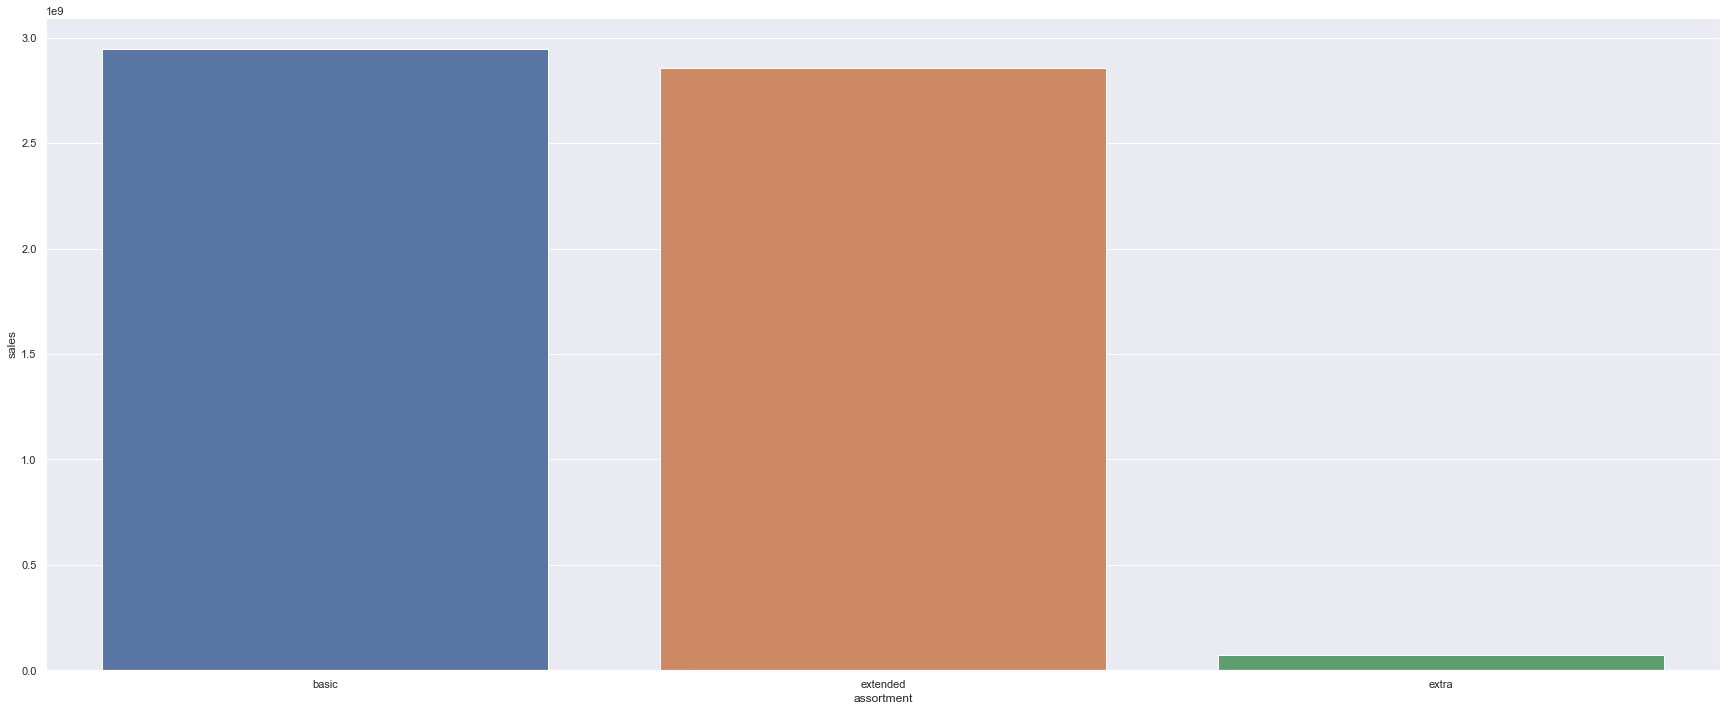

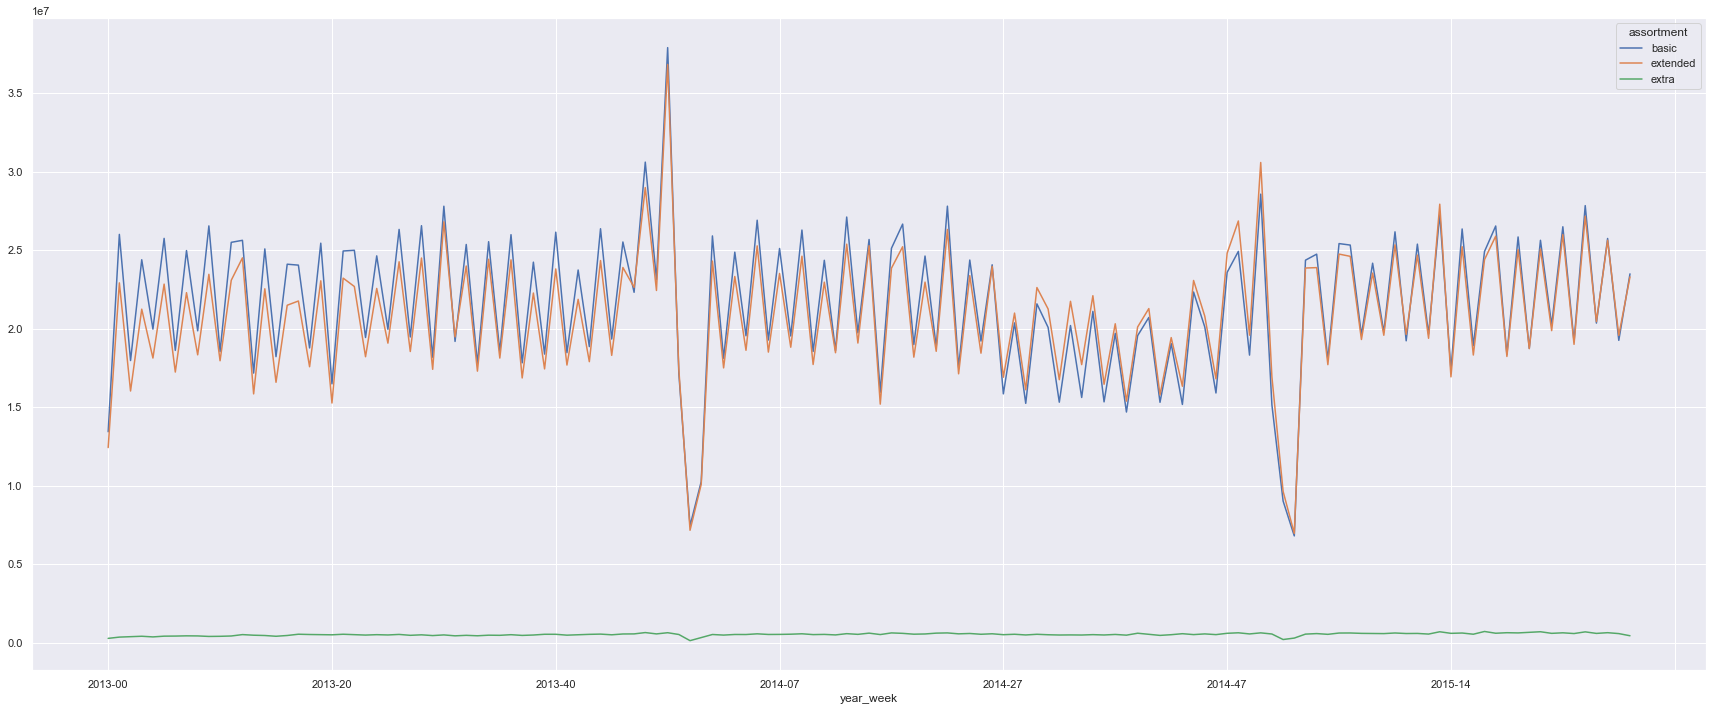

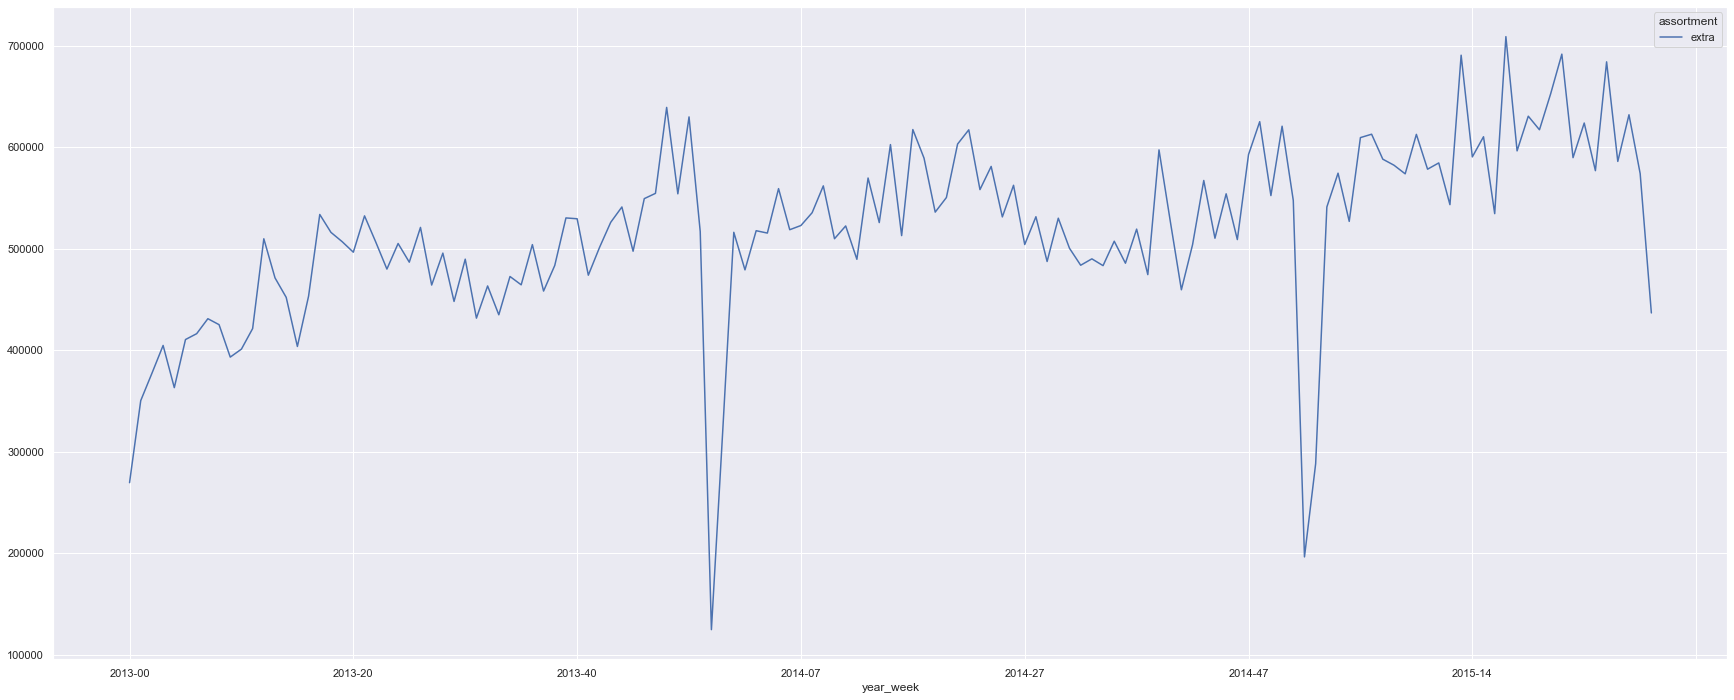

In [35]:
aux1 = df4[['assortment','sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 )

aux2 = df4[['year_week','assortment','sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week',columns='assortment' , values='sales' ).plot()

aux3 = aux2[ aux2['assortment'] == 'extra' ]
aux3.pivot( index='year_week',columns='assortment' , values='sales' ).plot()


In [36]:
aux2.head()

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693


### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSE** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

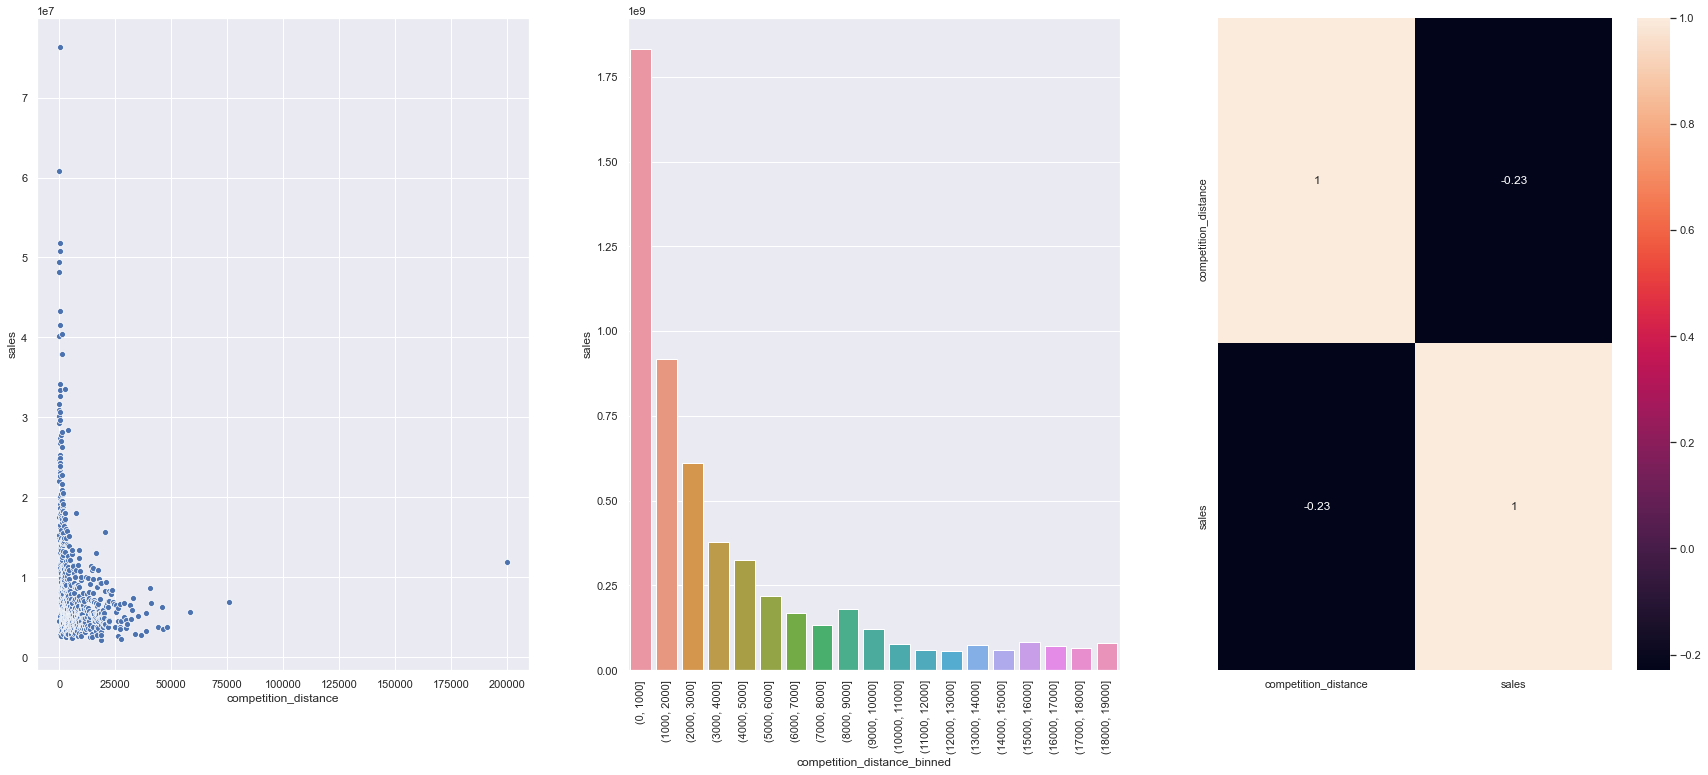

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.scatterplot( x= 'competition_distance', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
bins = list( np.arange( 0, 20000, 1000 ) )
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins )
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2);
plt.xticks( rotation=90 );


plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );


In [38]:
aux1.sample(4)

,competition_distance,sales,competition_distance_binned
610,21930.0,6285458,NaN
578,18020.0,5428994,"(18000.0, 19000.0]"
296,3870.0,7669453,"(3000.0, 4000.0]"
335,4680.0,5242001,"(4000.0, 5000.0]"


### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com COMPETIDORES À MAIS TEMPO vendem MAIS.

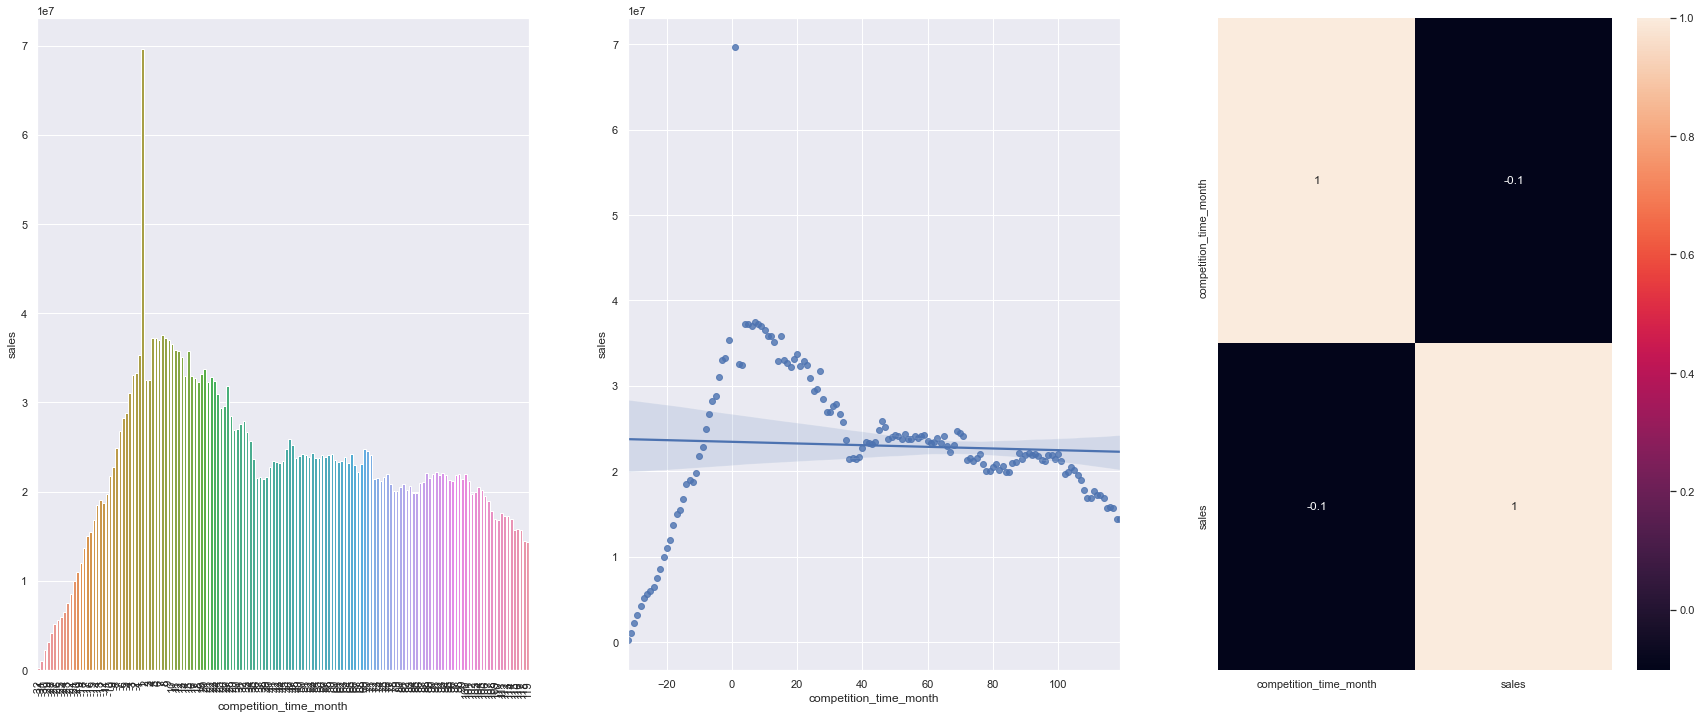

In [39]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_time_month', 'sales']].groupby( 'competition_time_month' ).sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x='competition_time_month', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_time_month', y='sales', data=aux2 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot = True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo periodo de promocao

In [40]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


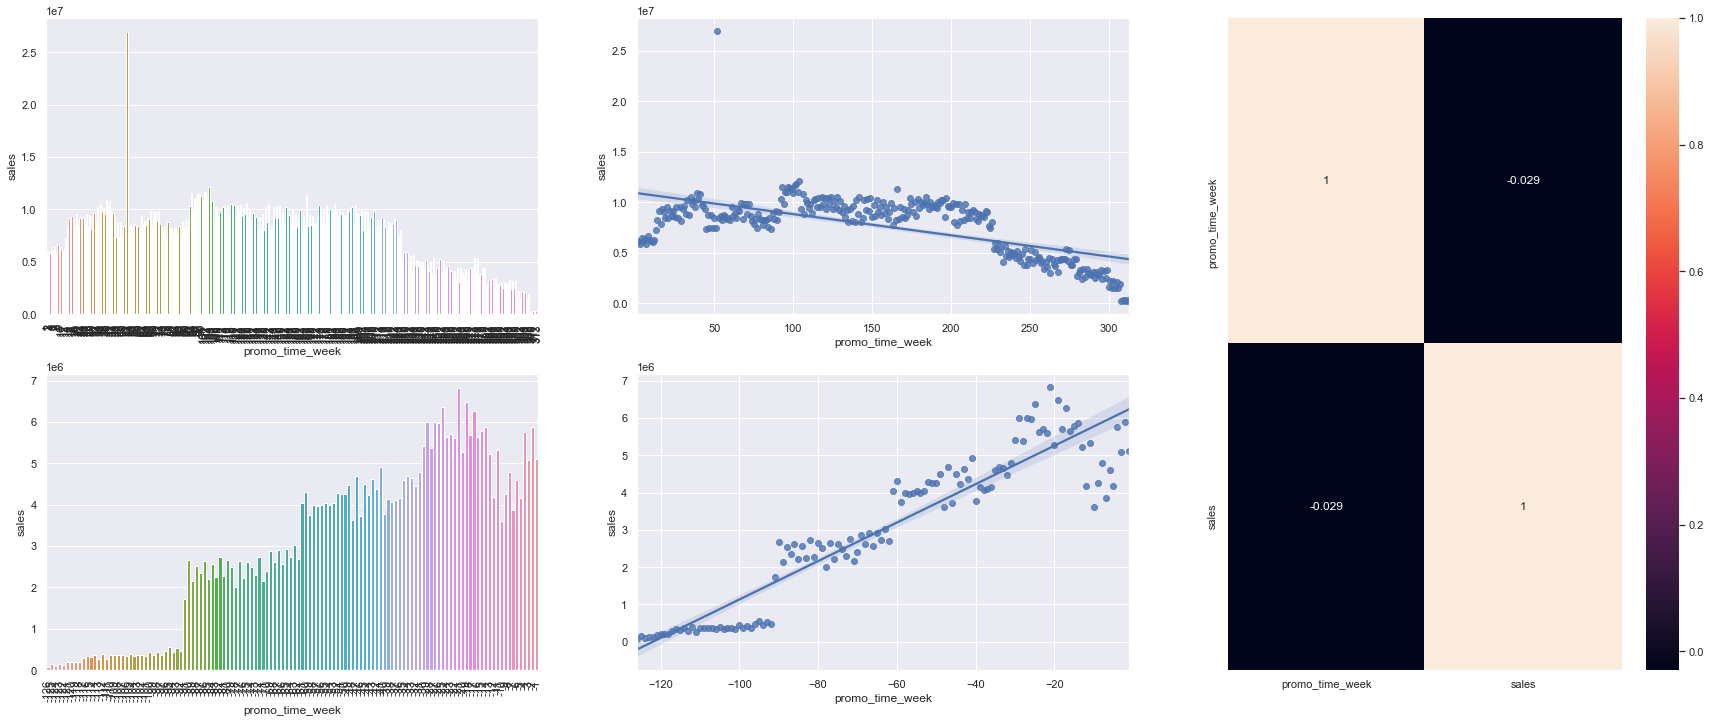

In [41]:
aux1 = df4[['promo_time_week','sales']].groupby( 'promo_time_week' ).sum().reset_index()
sns.barplot( x='promo_time_week', y='sales', data=aux1 );

grid = GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation = 90 );

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1, 0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation = 90 );

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:, 2] )
sns.heatmap( aux1.corr(method = 'pearson'), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [42]:
df4[['promo','promo2','sales']].groupby( ['promo','promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


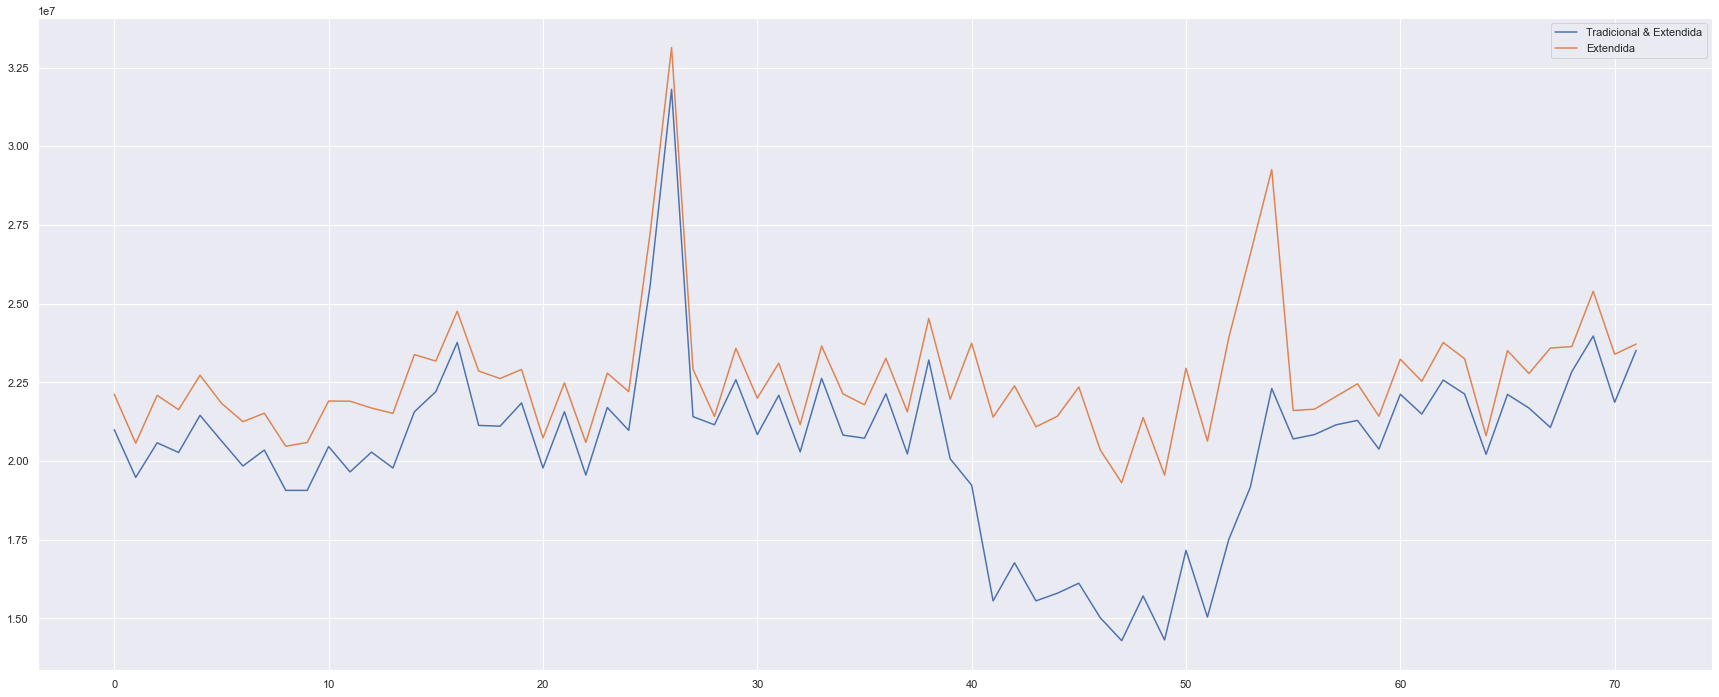

In [43]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels = ['Tradicional & Extendida', 'Extendida' ])

### **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de Natal vendem menos.

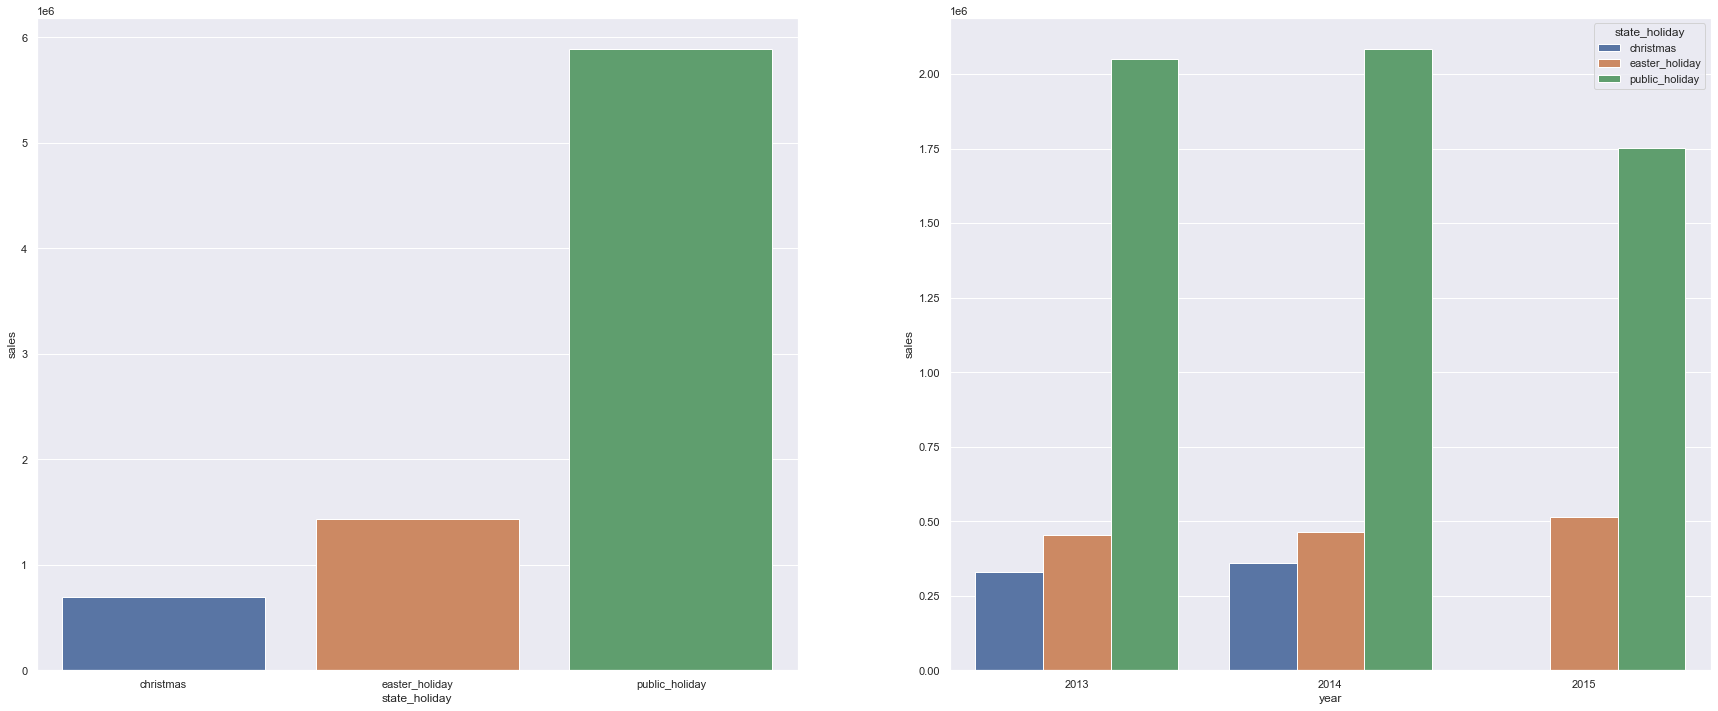

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday','sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1);

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday','sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H9.** Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

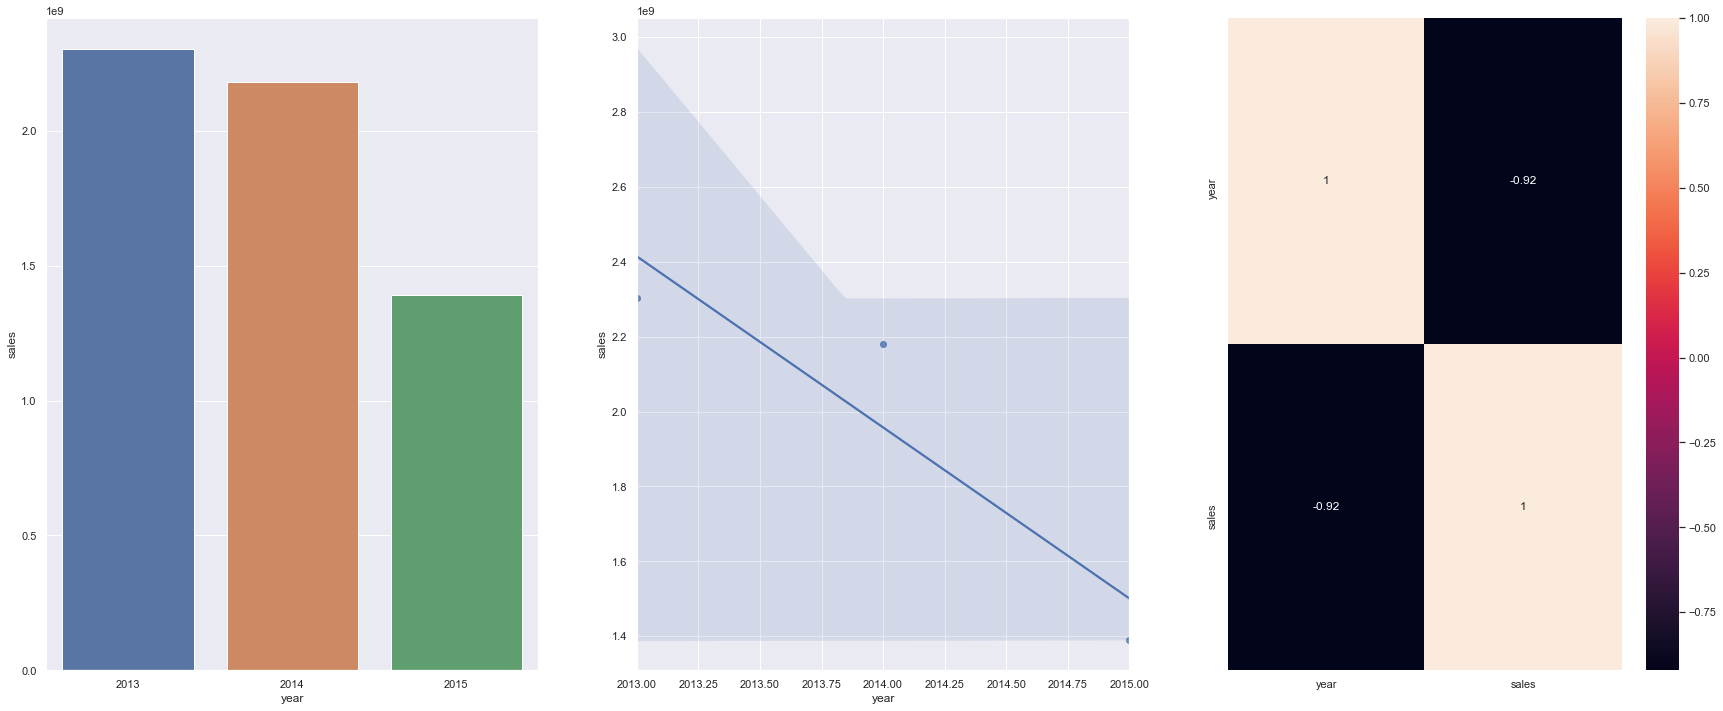

In [45]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

### **H10.** Lojas deveriam vender mais no segundo semestre do ano.jupyter_settings()

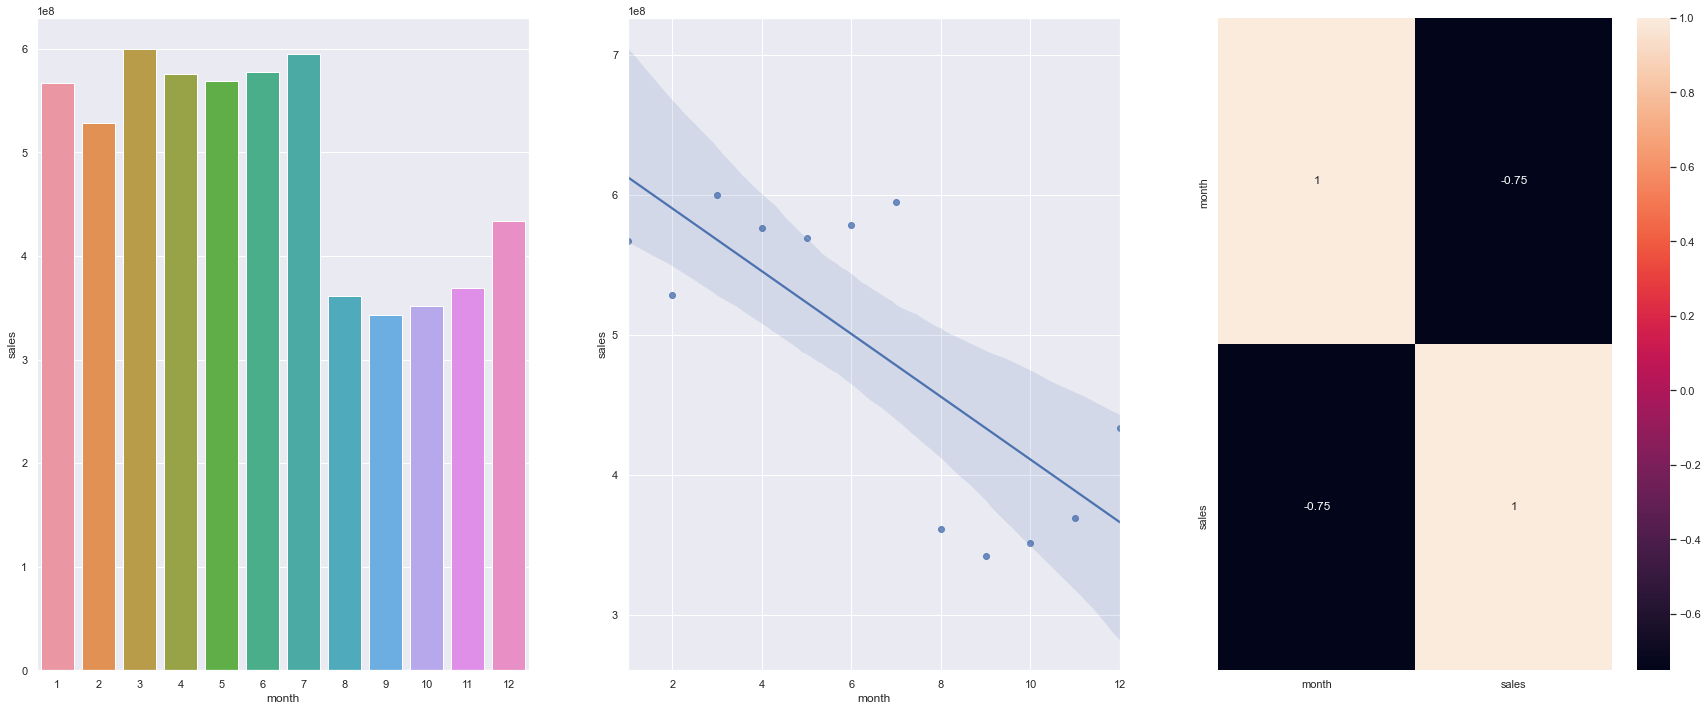

In [46]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

In [47]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


### **H11.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

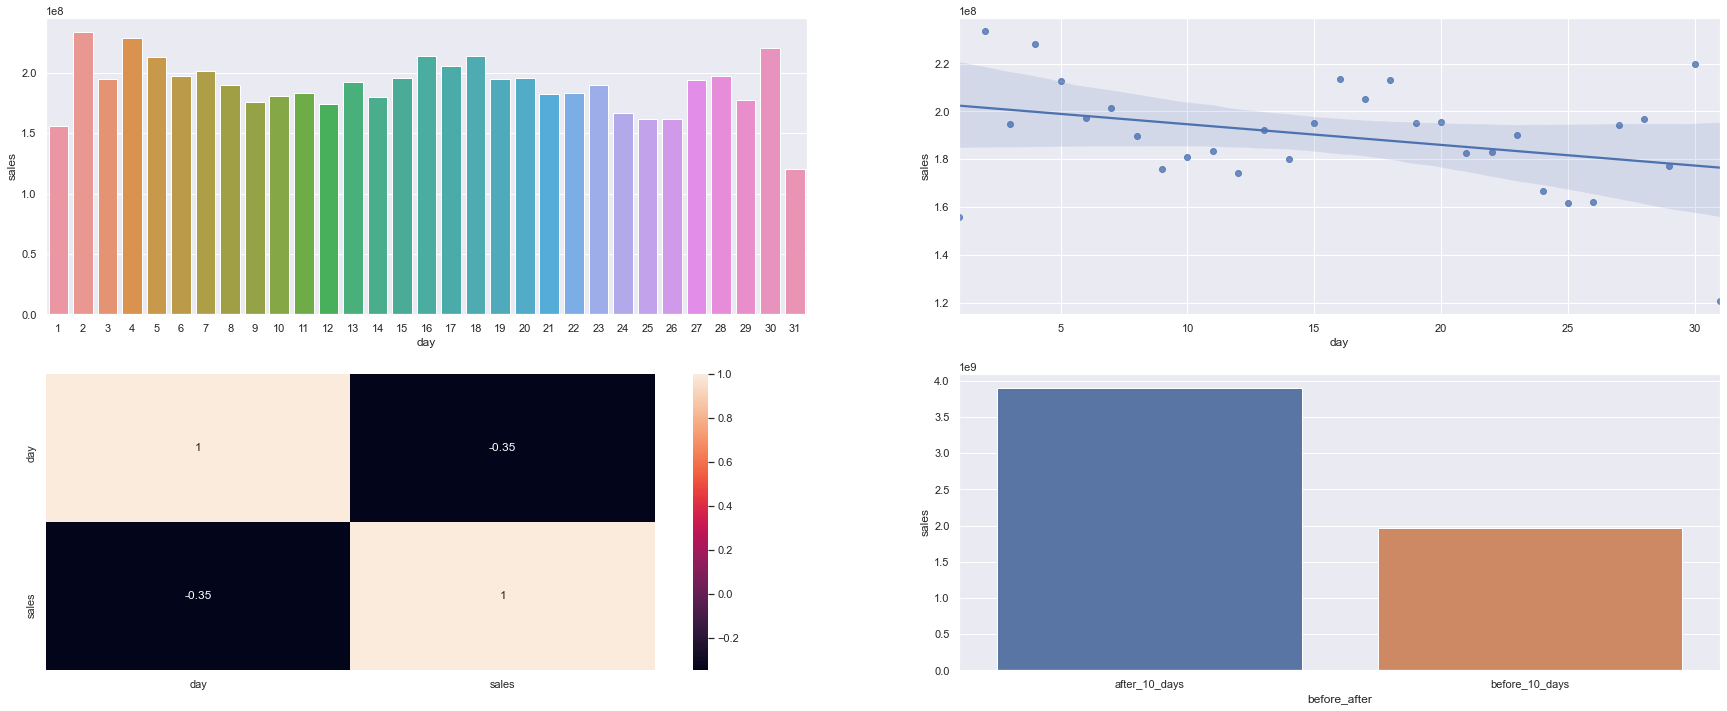

In [48]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 = aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 )

### **H12.** Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana.

In [49]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


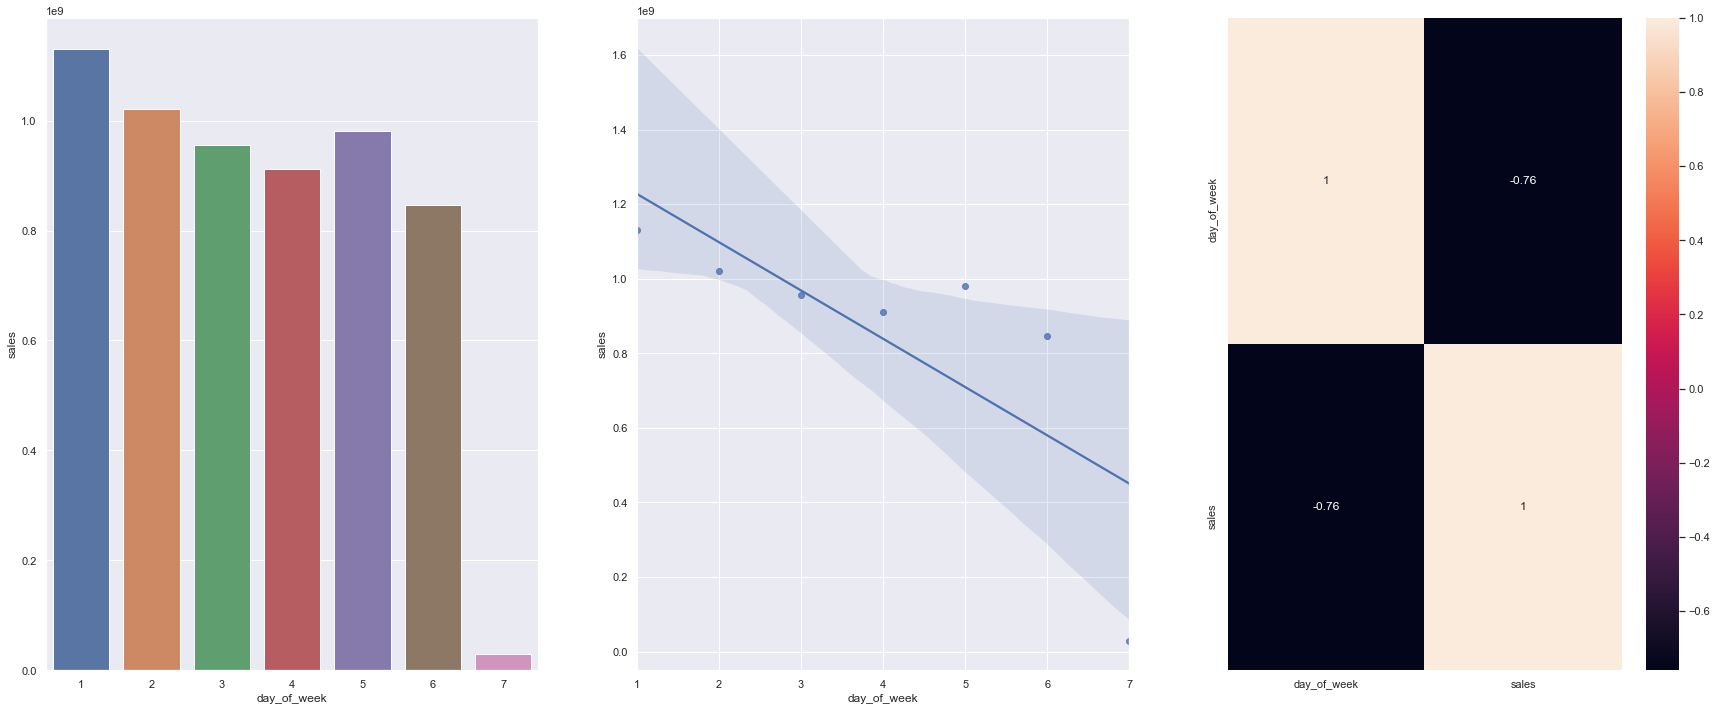

In [50]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr(method = 'pearson'), annot = True )

### **H13.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto.

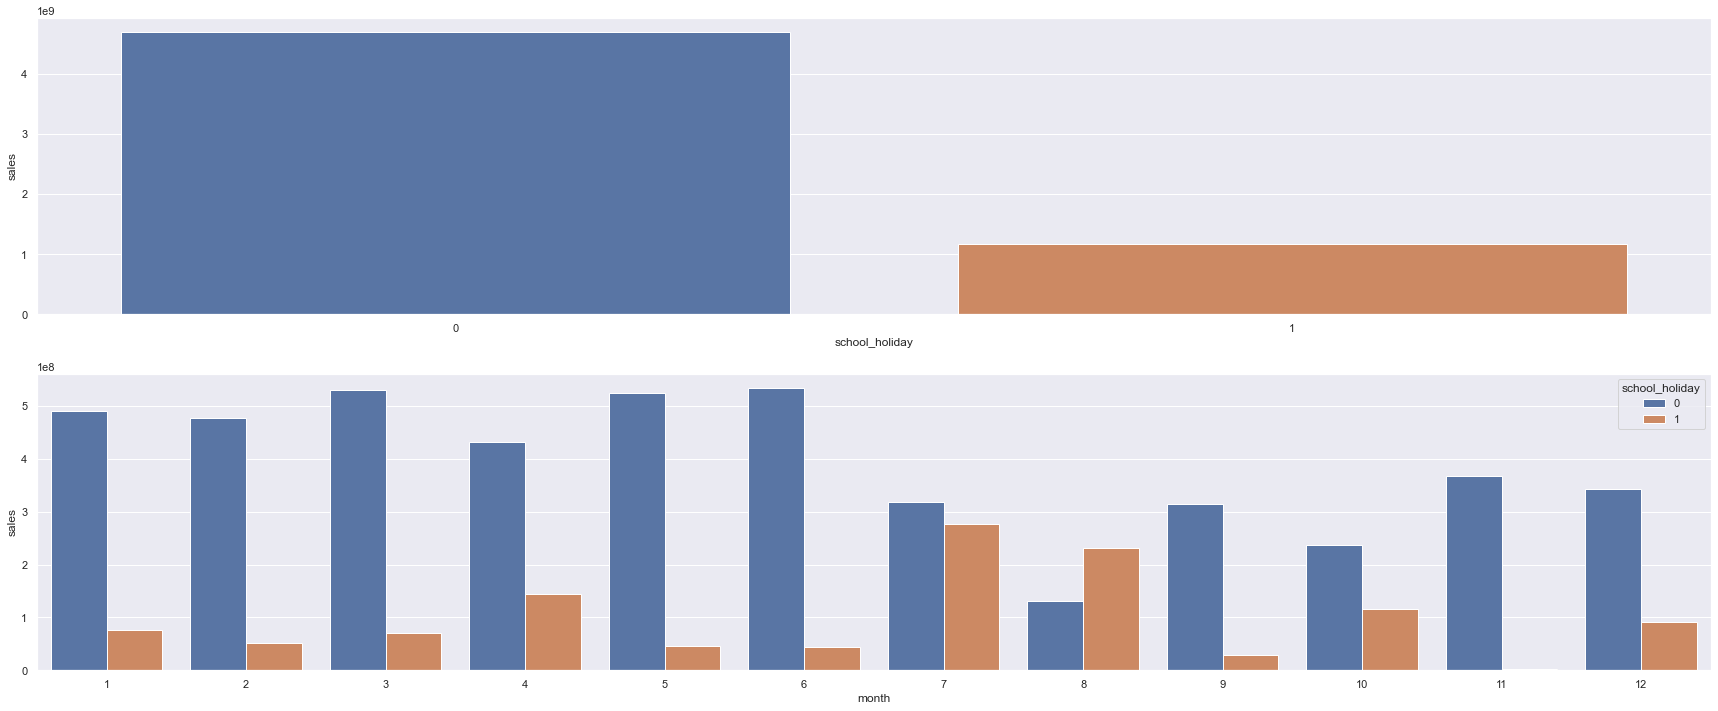

In [51]:
aux1 = df4[['school_holiday','sales']].groupby( 'school_holiday' ).sum().reset_index()

plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );

aux2 = df4[['month', 'school_holiday','sales']].groupby( ['month', 'school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

In [52]:
from tabulate import tabulate

In [53]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H8', 'Falsa', 'Media'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Falsa', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Alta'],
      ['H13', 'Verdadeira', 'Baixa'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.1. Analise Multivariada

### 4.3.1. Variaveis numericas
#### Correlação de pearson para analise das variaveis numericas

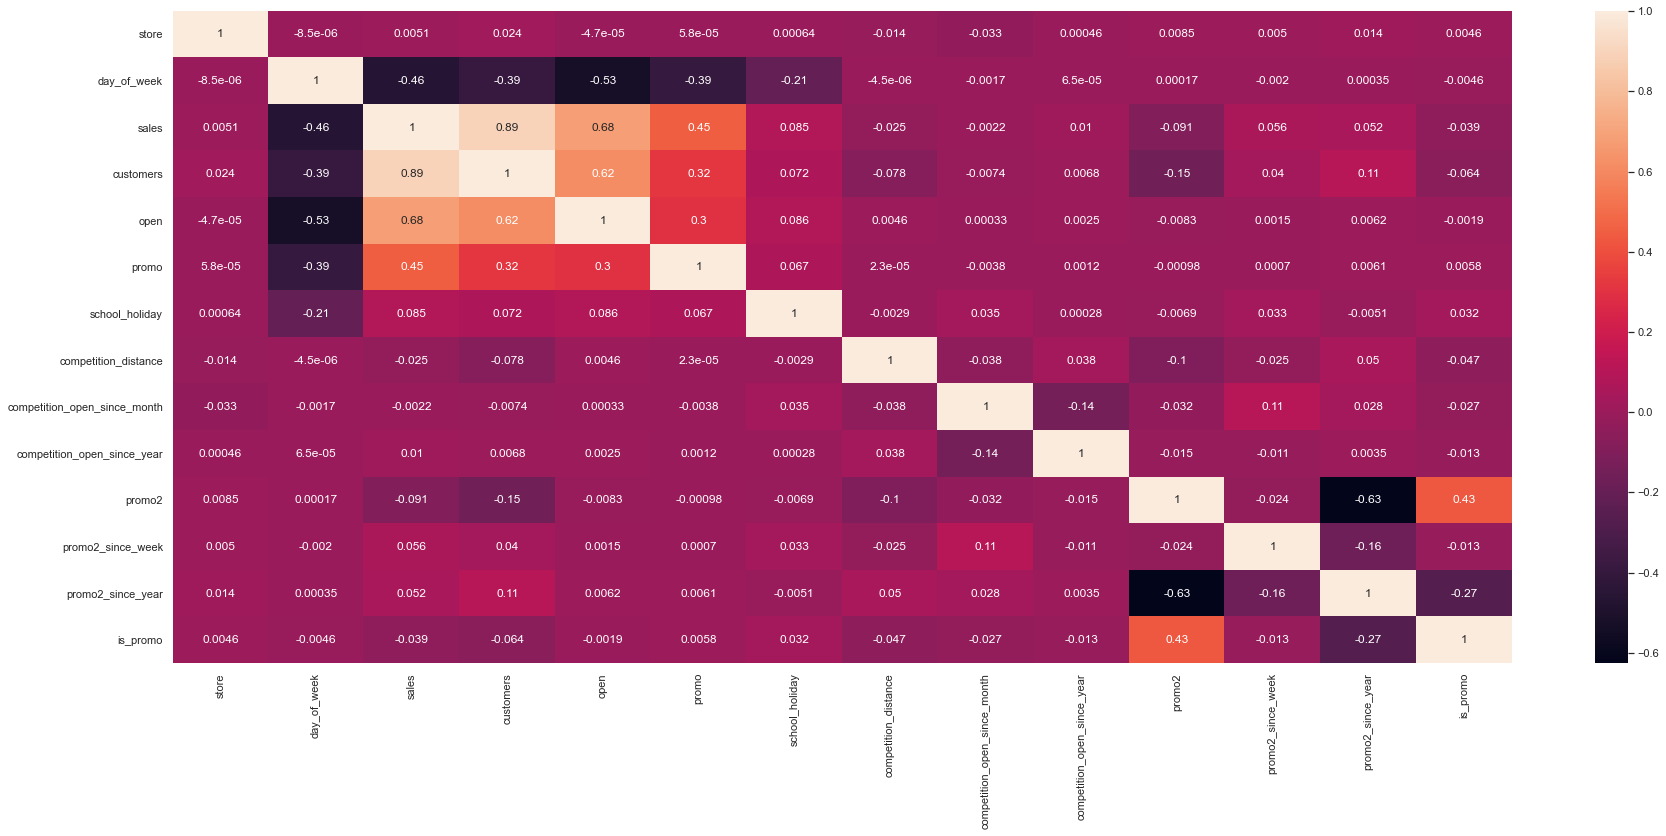

In [54]:
correlation = num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True )

### 4.3.2. Variaveis categóricas
#### Medindo correlação entre as variaveis categóricas através do calculo do V de Cramer

In [55]:
# Função para calculo do V de cramer, para medir a correlação entre variaveis categóricas (nominais)
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0,chi2 - (k-1)*(r-1)/(n-1) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1,rcorr-1 ) ) )

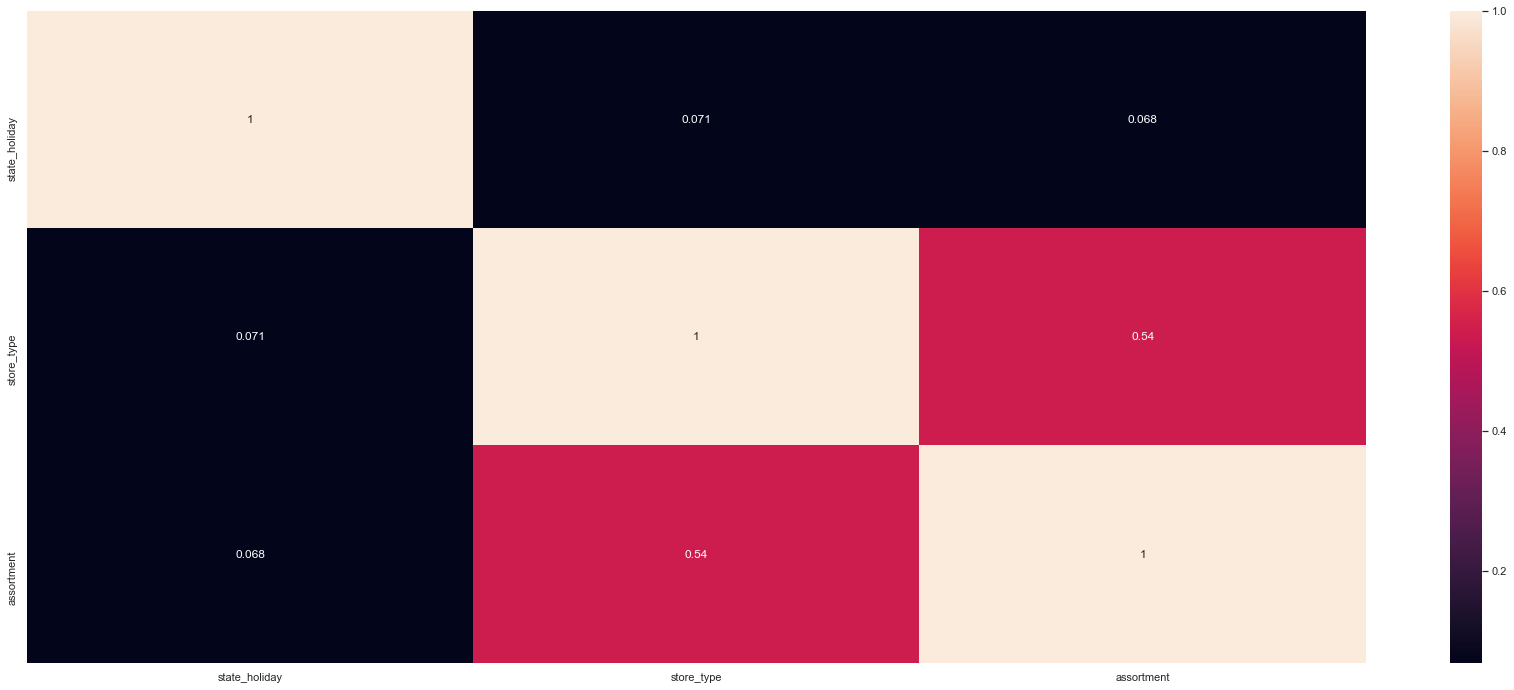

In [56]:
# Selecionando variaveis categoricas
a = df4.select_dtypes( include = 'object' )

# Calculando o V de Cramer com a função criada acima para medir a correlação entre variaveis categóricas
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )

a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )

a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Dataset final concatenando os resultados dos calculos
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] } )

d = d.set_index( d.columns )

sns.heatmap(d, annot = True)

# 5.0. PASSO 05 - DATA PREPARATION

In [57]:
df5 = df4.copy()

## 5.1. Rescaling
### Rescaling de variaveis para coloca-las no mesmo range de valores

In [58]:
# Robust Scaler, não sensivel a outliers, indicado para variaveis que possuem range muito grande devido a outliers
rs = RobustScaler()
# Min Max Scaler, sensivel a outliers, indicado para variaveis que não possuem outliers muito discrepantes
mms = MinMaxScaler()

# Aplicação do Robust Scaler devido a variavel apresentar outliers
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
# Utilização da biblioteca pickle para salvar a função e exportar para ser utilizada na api
pickle.dump( rs, open( 'parameter/competition_distance_scaler.pkl', 'wb' ) )

# Aplicação do Robust Scaler devido a variavel apresentar outliers
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
# Utilização da biblioteca pickle para salvar a função e exportar para ser utilizada na api
pickle.dump( rs, open( 'parameter/competition_time_month_scaler.pkl', 'wb' ) )

# Aplicação do Min Max Scaler devido a variavel não apresentar outliers
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
# Utilização da biblioteca pickle para salvar a função e exportar para ser utilizada na api
pickle.dump( mms, open( 'parameter/promo_time_week_scaler.pkl', 'wb' ) )

# Aplicação do Min Max Scaler devido a variavel não apresentar outliers
df5['year'] = mms.fit_transform( df5[['year']].values )
# Utilização da biblioteca pickle para salvar a função e exportar para ser utilizada na api
pickle.dump( mms, open( 'parameter/year_scaler.pkl', 'wb' ) )

## 5.2. Transformação

### 5.2.1. Encoding
#### Aplicação de algumas técnicas de encoding em variaveis categóricas

In [59]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_s

In [60]:
# One Hot Encoding, utilizado esse tipo de encoding por ser simples, e devido também a nossa variavel categórica não possuir tantas categorias
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns = ['state_holiday'] )

# Label Encoding, utilizado esse tipo de encoding pelas categorias não apresentarem nenhuma ordem de grandeza
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
# Utilização da biblioteca pickle para salvar a função e exportar para ser utilizada na api
pickle.dump( le, open( 'parameter/store_type_encoding.pkl', 'wb' ) )

# Ordinal Encoding, utilizado esse tipo de encoding pelas categorias apresentarem ordem de grandeza
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.2.2. Transformação da variavel resposta
#### Aplicação de logaritmo na variavel resposta para transforma-la mais próxima de uma normal

In [61]:
df5['sales'] = np.log1p( df5['sales'] )
#sns.distplot(df5['sales'])

### 5.2.3. Transformação de Natureza
#### Nesse contexto, as transformações de natureza estão sendo aplicadas em variaveis como dia, mês e semana, para preservar suas caracteristicas ciclicas

In [62]:
# Transformação de natureza do mês, o objetivo é preservarmos a questão ciclica da variavel
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# # Transformação de natureza do dia, o objetivo é preservarmos a questão ciclica da variavel
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# # Transformação de natureza da semana do ano, o objetivo é preservarmos a questão ciclica da variavel
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# # Transformação de natureza do dia da semana, o objetivo é preservarmos a questão ciclica da variavel
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )


# 6.0. PASSO 06 - Seleção de Features

In [63]:
df6 = df5.copy()

## 6.1. Separação dos dados em treino e test

In [64]:
# Dropando variaveis que não serão usadas
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop( cols_drop, axis=1 )

In [65]:
# A idéia é separar as 6 ultimas semanas para testar o dataset, então pegamos a ultima data do dataset menos a data de 6 semanas
df6[['store', 'date']].groupby( 'store' ).max().reset_index()['date'][0] - datetime.timedelta( days=6*7 )

Timestamp('2015-06-19 00:00:00')

In [66]:
# Dados de treino, filtrando todos os dados menos as ultimas 6 semanas
X_train = df6[df5['date'] < '2015-06-19']
y_train = X_train['sales']

# Dados de teste, filtrando os dados das ultimas 6 semanas
X_test = df6[df5['date'] >= '2015-06-19']
y_test = X_test['sales']

# Printando as datas dos dados de treino e teste
print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( 'Test Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00
Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta para selecionar Features
### Utilização do algoritmo Boruta para seleção das variaveis que serão utilizadas no modelo
Obs: O código está cometando devido a execução ser demorada

In [67]:
# Dados de treino e teste para o Boruta
# X_train_n = X_train.drop( ['date','sales'], axis=1 ).values
# y_train_n = y_train.values.ravel()

# Instanciando o Random Forest para passar como parâmetro de seleção para o Algoritmo Boruta
# rf = RandomForestRegressor( n_jobs=-1 )

# Definindo Boruta com os parâmetros
# boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n )

### 6.2.1. Melhores features do Boruta

In [68]:
# Lista com as colunas selecionadas pelo Boruta
# cols_selected = boruta.support_.tolist()

# Melhores variaveis
# X_train_fs = X_train.drop( ['date','sales'], axis=1 )
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# Variaveis não selecionadas
# cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

## 6.3. Seleção Manual das Features
### Dada a lista de melhores features pelo Boruta, salvamos manualmente abaixo

In [69]:
# Colunas selecionadas pelo Boruta
cols_selected_boruta = [ 'store',
                         'promo',
                         'store_type',
                         'assortment',
                         'competition_distance',
                         'competition_open_since_month',
                         'competition_open_since_year',
                         'promo2',
                         'promo2_since_week',
                         'promo2_since_year',
                         'competition_time_month',
                         'promo_time_week',
                         'week_of_year_sin',
                         'day_of_week_sin',
                         'day_of_week_cos' ]

cols_not_selected_boruta = [ 'day_cos',
                             'day_sin',
                             'is_promo',
                             'month_cos',
                             'month_sin',
                             'school_holiday',
                             'state_holiday_christmas',
                             'state_holiday_easter_holiday',
                             'state_holiday_public_holiday',
                             'state_holiday_regular_day',
                             'week_of_year_cos',
                             'year' ]

# Variaveis para adicionar no dataset
feat_to_add = ['date', 'sales']

# Variaveis finais
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - Modelagem de Machine Learning
### Nessa etapa alguns modelos foram utilizados para comparação de performance

In [70]:
# Dados treino e teste com as variaveis selecionadas pelo algoritmo Boruta
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Dados de treino com as variaveis selecionadas pelo algoritmo Boruta e as variaveis date e sales
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [71]:
# Modelo de média servirá como uma base comparativa para os demais modelos
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# Predição
aux2 = aux1[['store','sales']].groupby( 'store' ).mean().reset_index().rename( columns = {'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left',on='store' )
yhat_baseline = aux1['predictions']

# Performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,Mae,Mape,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [72]:
# Instancia e fit do modelo de regressão linear
lr = LinearRegression().fit( x_train, y_train )

# Predicão
yhat_lr = lr.predict( x_test )

# Performance
lr_result = ml_error( 'Linear Regressor', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result


,Model Name,Mae,Mape,RMSE
0,Linear Regressor,1885.617328,0.305455,2655.281782


## 7.2.1. Linear Regression Model - Validação Cruzada

In [73]:
# Validação cruzada do modelo de regressão linear
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2059.6 +/- 288.33,0.3 +/- 0.01,2935.28 +/- 436.39


## 7.3. Linear Regression Regularized Model - Lasso

In [74]:
# Instancia e fit do modelo regularizado de regressão linear lasso
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# Predicão
yhat_lrr = lrr.predict( x_test )

# Performance
lrr_result = ml_error( 'Linear Regressor', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result


,Model Name,Mae,Mape,RMSE
0,Linear Regressor,1911.907333,0.296576,2754.233599


## 7.3.1. Lasso - Validação Cruzada

In [75]:
# Validação cruzada do modelo regularizado de regressão linear lasso
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2117.91 +/- 323.7,0.29 +/- 0.01,3060.0 +/- 473.8


## 7.4. Random Forest Regressor

In [76]:
# Instancia e fit do modelo de random forest
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# Predição
yhat_rf = rf.predict( x_test )

# Performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,670.374433,0.099307,987.331001


## 7.4.1. Random Forest Regressor - Validação Cruzada

In [77]:
# Validação cruzada do modelo de random forest
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,931.34 +/- 267.38,0.13 +/- 0.02,1394.05 +/- 419.86


## 7.5. XGBoost Regressor

In [78]:
# Instancia e fit do modelo xgboost
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# Predição
yhat_xgb = model_xgb.predict( x_test )

# Performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,926.868034,0.139041,1325.661661


## 7.5.1. XGBoost Regressor - Validação Cruzada

In [79]:
# Validação cruzada do modelo xgboost
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1077.77 +/- 232.99,0.15 +/- 0.02,1585.44 +/- 364.19


## 7.6. Comparação da Performance dos Modelos

## 7.6.1. Performance individual

In [80]:
# Comparação da performance individual dos modelos
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values( 'RMSE' )

,Model Name,Mae,Mape,RMSE
0,Random Forest Regressor,670.374433,0.099307,987.331001
0,XGBoost Regressor,926.868034,0.139041,1325.661661
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regressor,1885.617328,0.305455,2655.281782
0,Linear Regressor,1911.907333,0.296576,2754.233599


## 7.6.2. Performance Real - Validação Cruzada

In [81]:
# Comparação da performance dos modelos pelo método de validação cruzada
modelling_result = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2059.6 +/- 288.33,0.3 +/- 0.01,2935.28 +/- 436.39
0,Lasso,2117.91 +/- 323.7,0.29 +/- 0.01,3060.0 +/- 473.8
0,Random Forest Regressor,931.34 +/- 267.38,0.13 +/- 0.02,1394.05 +/- 419.86
0,XGBoost Regressor,1077.77 +/- 232.99,0.15 +/- 0.02,1585.44 +/- 364.19


In [82]:
# Model   Name	                        MAE CV 	                 MAPE CV	                   RMSE CV
# 0	      Linear Regression	        2059.6 +/- 288.33	      0.3 +/- 0.01	               2935.28 +/- 436.39
# 0	      Lasso	                    2117.91 +/- 323.7	      0.29 +/- 0.01	               3060.0 +/- 473.8
# 0	      Random Forest Regressor	931.34 +/- 267.38	      0.13 +/- 0.02	               1394.05 +/- 419.86
# 0	      XGBoost Regressor	        1077.77 +/- 232.99	      0.15 +/- 0.02	               1585.44 +/- 364.

# 8.0. PASSO 08 - Ajuste dos hiperparâmetros
### Nessa etapa foi utilizado a estratégia de Random Search com 5 iterações para ajuste nos hiperparametros
Obs: O código está comentado por se tratar de uma etapa muito demorada

## 8.1. Random Search

In [83]:
# Parâmetros randomicos para utilizar no Random Search
# param = {
#     'n_estimators': [1500,1700,2500,3000,3500],
#     'eta': [0.01,0.03],
#     'max_depth': [3,5,9],
#     'subsample': [0.1,0.5,0.7],
#     'colsample_bytree': [0.3,0.7,0.9],
#     'min_child_weight': [3,8,15]
#         }

# MAX_EVAL = 5

In [84]:
# final_result = pd.DataFrame()

# for i in range ( MAX_EVAL):
#     # Escolhendo os parâmetros randomicamente
#     hp = { k: random.sample ( v, 1)[0] for k, v in param.items() }
#     print( hp )
    
#     # Modelo
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                   n_estimators=hp['n_estimators'], 
#                                   eta=hp['eta'],
#                                   max_depth=hp['max_depth'],
#                                   subsample=hp['subsample'],
#                                   colsample_bytree=hp['colsample_bytree'],
#                                   min_child_weight=hp['min_child_weight'] )
    
#     # Performance
#     result = cross_validation( x_training, 2, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )
    
# final_result

## 8.2. Modelo Final
### Modelo final com os melhores parâmetros de acordo com o Random Search

In [85]:
# Parâmetros do modelo final
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }


In [86]:
# Instancia e fit do modelo final de xgboost
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytree=param_tuned['colsample_bytree'],
                                    min_child_wei1ght=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# Predição
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# Performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1 ( yhat_xgb_tuned) )
xgb_result_tuned

,Model Name,Mae,Mape,RMSE
0,XGBoost Regressor,772.553166,0.112165,1129.829667


In [87]:
# Com a porcentagem do erro médio, podemos obter o quanto o modelo esta superestimando (valores preditos acima do real) e o quanto está subestimando (valores preditos abaixo do real),
# no caso como é negativo (ainda que pequeno), o modelo tem a tendencia a superestimar os valores
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.023705682654974927

In [88]:
# Com a porcentagem da raiz do erro médio ao quadrado, podemos obter o quanto o modelo está errando em porcentagem
rmspe = root_mean_square_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
rmspe * 100

15.31133573938456

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO
### Nessa etapa será realizado uma simulação da tradução e interpretação dos erros em conceitos de negócio, de modo que fique mais apresentavel os resultados do modelo

In [89]:
# Selecionando todas as variaveis necessarias
df9 = X_test[ cols_selected_boruta_full]

# Aplicando exponencial para retirar a variavel real sales e a variavel predita predictions da escala logaritmica
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned)

## 9.1. Performance de Negócio

In [90]:
# Group das predições por store
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# Calculo do erro absoluto médio (MAE) e da porcentagem do erro absoluto médio (MAPE)
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'} )
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'} )

# Merge dos erros calculados acima com as predições agrupadas por loja
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Cenários
df92['pior_cenario'] = df92['predictions'] - df92['MAE']
df92['melhor_scenario'] = df92['predictions'] + df92['MAE']

# Ordenação das colunas
df92 = df92[['store', 'predictions', 'pior_cenario', 'melhor_scenario', 'MAE', 'MAPE']]

In [91]:
# Ordenando os menores valores do MAPE
df92.sort_values( 'MAPE', ascending=True ).head()  

,store,predictions,pior_cenario,melhor_scenario,MAE,MAPE
532,533,394771.593750,394099.935494,395443.252006,671.658256,0.060337
48,49,282428.406250,281952.192264,282904.620236,476.213986,0.061245
1040,1041,233507.234375,233113.418893,233901.049857,393.815482,0.061994
498,499,205278.734375,204938.151222,205619.317528,340.583153,0.062263
693,694,311013.031250,310474.251993,311551.810507,538.779257,0.062729


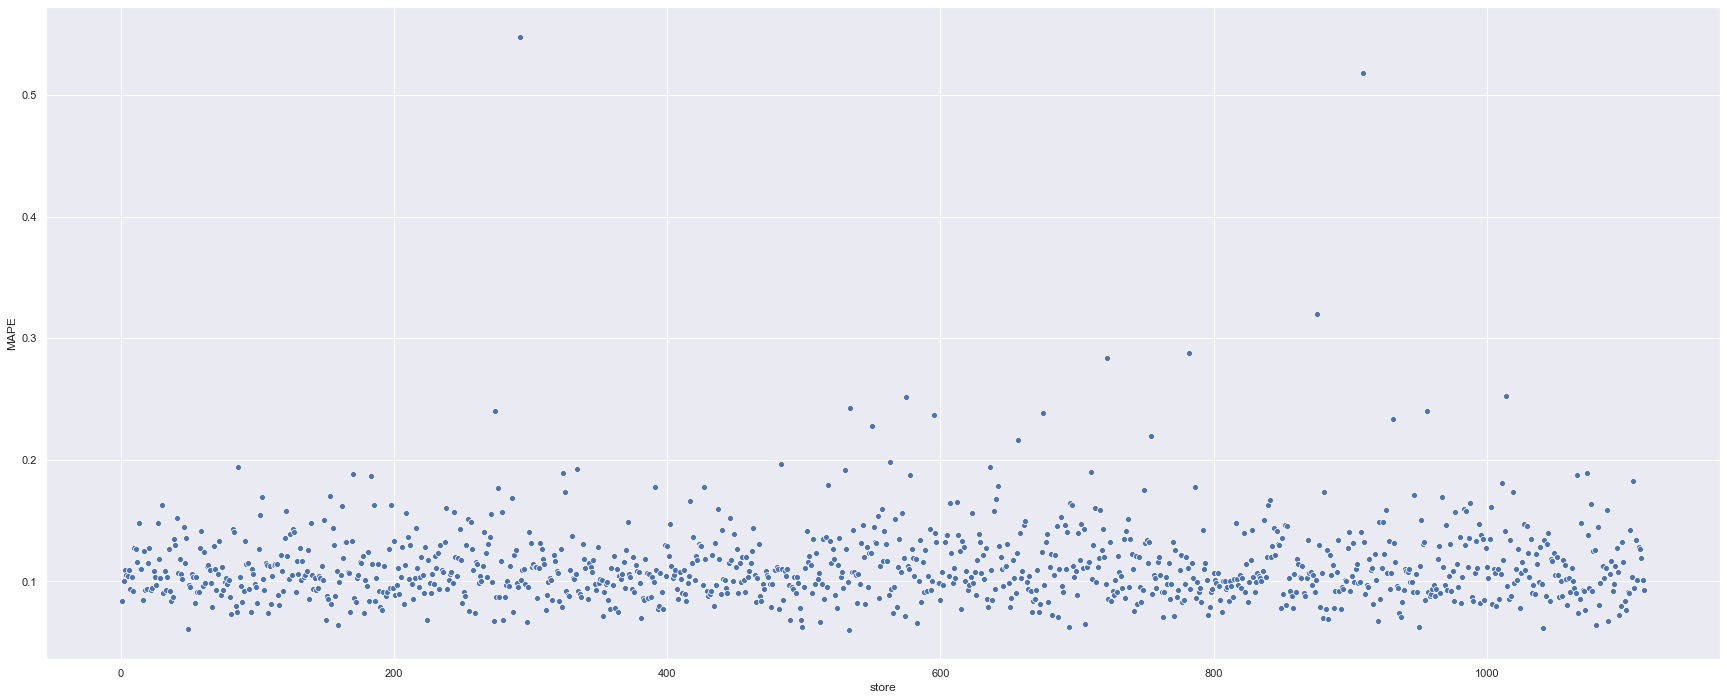

In [92]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Resumo da performance

In [93]:
# Resumo da predição no pior e melhor cenarios
df93 = df92[['predictions', 'pior_cenario', 'melhor_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns= {'index': 'Cenarios', 0:'Valores' } )
df93['Valores'] = df93['Valores'].map( 'R${:,.2f}'.format )
df93

,Cenarios,Valores
0,predictions,"R$291,659,584.00"
1,pior_cenario,"R$290,794,407.24"
2,melhor_scenario,"R$292,524,719.98"


## 9.3. Análise de residuos e erros do modelo de Machine Learning

In [94]:
# Verificando o erro do predito em relação ao real
df9['error'] =df9['sales'] -df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

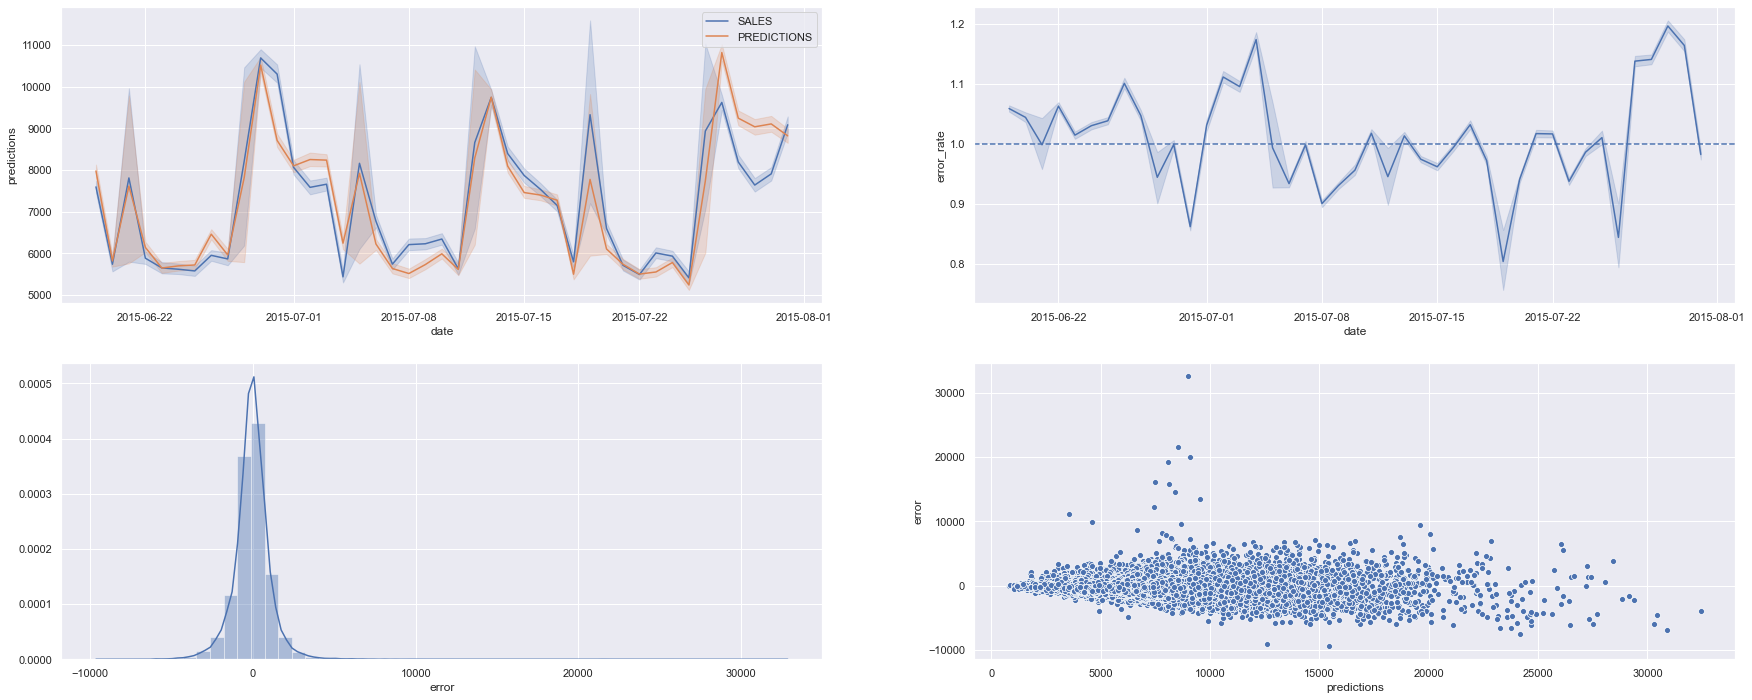

In [95]:
# Análise de residuos e erros do modelo
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1,linestyle = '--' )


plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. PASSO 10 - DEPLOY DO MODELO PARA PRODUÇÃO NO HEROKU
### Nesse passo será criado os scripts necessários para colocar o modelo em produção na plataforma Heroku
Obs: Os códigos estão comentados pois o intuito é somente demonstrativo dos scripts utilizados para o deploy

In [96]:
# Modelo salvo com pickle para utilização na api
pickle.dump( model_xgb_tuned, open( 'C:/Users/luuca/Documents/Projetos/Python/Rossmann-Store-Sales/model/rossmann_model.pkl','wb' ) )

## 10.1. Classe Rossmann
### Classe com funções de todos os processamentos de dados necessarios para o modelo, para deploy do modelo, foram realizados modificações para atender a plataforma Heroku

In [97]:
# import pickle
# import inflection
# import pandas as pd
# import numpy as np
# import math
# import datetime

# class Rossmann( object ):
#     def __init__( self ):
#         self.home_path = 'C:/Users/luuca/Documents/Projetos/Python/Rossmann-Store-Sales/'
#         self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb' ) )
#         self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb' ) )
#         self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb' ) )
#         self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/yeark_scaler.pkl', 'rb' ) )
#         self.store_tyoe_encoding           = pickle.load( open( self.home_path + 'parameter/store_type_encoding.pkl', 'rb' ) )
        
#     def data_cleaning( self, df1 ):
#         ## 1.1. Renomeando colunas
#         cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
#                     'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#         snakecase = lambda x: inflection.underscore( x )

#         cols_new = list(map(snakecase, cols_old))

#         df1.columns = cols_new

#         ## 1.3. Mudando para tipo data

#         df1['date'] = pd.to_datetime(df1['date'])

#         ## 1.5. Preenchendo NAs
#         # competition_distance
#         df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#         # competition_open_since_month    
#         df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#         # competition_open_since_year
#         df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#         # promo2_since_week
#         df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#         # promo2_since_year
#         df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#         # promo_interval
#         month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

#         df1['promo_interval'].fillna(0, inplace=True)

#         df1['month_map'] = df1['date'].dt.month.map( month_map )

#         df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis = 1 )

#         ## 1.6. Mudando os tipos dos dados
#         # competition
#         df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
#         df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )
        
#         # promo2
#         df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
#         df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )
        
#         return df1
    
#     def feature_engineering( self, df2 ):
#         # year
#         df2['year'] = df2['date'].dt.year

#         # month
#         df2['month'] = df2['date'].dt.month

#         # day
#         df2['day'] = df2['date'].dt.day

#         # week of year
#         df2['week_of_year'] = df2['date'].dt.isocalendar().week.astype(np.int64)

#         # year week
#         df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#         # competition since
#         df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
#         df2['competition_time_month'] = ( ( df2['date'] -df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype(np.int64)

#         # promo since
#         df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
#         df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x +'-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
#         df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( np.int64 )

#         # assortment
#         df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended'  )

#         # state holiday
#         df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day'  )

#         # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
#         ## 3.1. Filtragem das Linhas

#         df2 = df2[df2['open'] != 0]

#         ## 3.2. Seleção das Colunas
#         cols_drop = ['open', 'promo_interval', 'month_map']
#         df2 = df2.drop( cols_drop, axis = 1 )
        
#         return df2
    
    
#     def data_preparation( self, df5):
#         ## 5.2. Rescala
#         # competition distance
#         df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

#         # competition time month
#         df5['competition_time_month'] = self.competition_time_month.fit_transform( df5[['competition_time_month']].values )

#         # promo time week
#         df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
    
#         # year
#         df5['year'] = self.year_week.fit_transform( df5[['year']].values )

#         ## 5.3. Transformação
#         ### 5.3.1. Encoding
#         # state_holiday - One Hot Encoding
#         df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns = ['state_holiday'] )

#         # store_type - Label Encoding
#         df5['store_type'] = self.store_type_enconding.fit_transform( df5['store_type'] )

#         # assortment - Ordinal Encoding
#         assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
#         df5['assortment'] = df5['assortment'].map( assortment_dict )

#         ### 5.3.3. Transformação de natureza
#         # month
#         df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
#         df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

#         # day
#         df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
#         df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

#         # week of year
#         df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
#         df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

#         # day of week
#         df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
#         df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
#         cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
#                                  'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'week_of_year_sin', 'day_of_week_sin',
#                                  'day_of_week_cos']
        
#         return df5[ cols_selected ]
    
#     def get_prediction( self, model, original_data, test_data ):
#         # Predição
#         pred = model.predict( test_data )
        
#         # Adicionado as predições no dataset original
#         original_data['prediction'] = np.expm1( pred )
        
#         return orginal_data.to_json( orient = 'records', data_format = 'iso' )

## 10.1. Handler da API
### Funções para manipulação da API

In [98]:
# import pickle
# import pandas as pd
# from flask             import Flask, request, Response
# from rossmann.Rossmann import Rossmann

# # Carregando o modelo
# model = pickle.load( open( 'C:/Users/luuca/Documents/Projetos/Python/Rossmann-Store-Sales/model/rossmann_model.pkl', 'rb' ) )

# # Inicialização da API
# app = Flask( __name__ )

# @app.route( '/rossmann/predict', methods=['POST'] )
# def rossmann_predict():
#     test_json = request.get_json()
    
#     if test_json: # there is data
#         if isinstance( test_json, dict ): # Exemplo unico
#             test_raw = pd.DataFrame( test_json, index=[0] )
        
#         else: # Exemplo multiplo
#             test_raw = pd.DataFrame( test_json, columns = test_json[0].keys() )
        
#         # Instanciando classe Rossmann
#         pipeline = Rossmann()
        
#         # Limpeza dos dados
#         df1 = pipeline.data_cleaning( test_raw )
        
#         # Feature engineering
#         df2 = pipeline.feature_engineering( df1 )
        
#         # Preparação dos dados
#         df3 = pipeline.data_preparation( df2 )
        
#         # Predição
#         df_response = pipeline.get_predictio( model, test_raw, df3 )
        
#         return df_response
        
#     else:
#         return Response( '{}', status=200, mimetype = 'application/json' )

# if __name__ == '__main__':
#     app.run( '0.0.0.0' )

## 10.3. Teste da API

In [99]:
# Carregando dados de teste
df10 = pd.read_csv( 'data/test.csv' )

In [100]:
# Merge dados de test e store
df_test = pd.merge( df10, df_store_raw, how='left', on = 'Store' )

# Escolhendo store para predição
df_test = df_test[df_test['Store'].isin([5,6,2,100,30])]

# Removendo dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [101]:
# Convertendo o dataframe para json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [102]:
# Chamada da API
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-sales-predict-model.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

# Utilizando método post
r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [103]:
# Convertendo o json recebido da API em dataframe novamente
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [104]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print( 'Loja número {} irá vender R${:,.2f} nas próximas 6 semanas'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Loja número 30 irá vender R$169,723.08 nas próximas 6 semanas
Loja número 100 irá vender R$364,209.52 nas próximas 6 semanas


## 10.4. Teste da API manualmente

In [105]:
data = {'Id': [27779,7606,14332,21357,30460], 
        'Store': [506,983,823,1060,646], 
        'DayOfWeek': [7,3,2,1,4], 
        'Date': ['2015-08-16','2015-09-09','2015-09-01','2015-08-24','2015-08-13'], 
        'Open': [0.0,1.0,1.0,1.0,1.0], 
        'Promo':[0,0,1,0,0], 
        'StateHoliday':[0,0,0,0,0],
        'SchoolHoliday':[0,0,0,0,1]}
data = pd.DataFrame(data)

In [106]:
data_raw = {'Store': [506,983,823,1060,646], 
            'StoreType': ['a','a','a','a','a'], 
            'Assortment': ['a','a','c','a','c'], 
            'CompetitionDistance': [220.0,620.0,16210.0,40.0,3430.0], 
            'CompetitionOpenSinceMonth':[2.0,9.0,11.0,3.0,float('NaN')], 
            'CompetitionOpenSinceYear':[2002.0,2014.0,2010.0,2014.0,float('NaN')],
            'Promo2':[1,0,0,1,1],
            'Promo2SinceWeek':[37.0,float('NaN'),float('NaN'),1.0,31.0],
            'Promo2SinceYear':[2009.0,float('NaN'),float('NaN'),2014.0,2013.0],
            'PromoInterval':['Jan,Apr,Jul,Oct',float('NaN'),float('NaN'),'Jan,Apr,Jul,Oct','Feb,May,Aug,Nov']}
data_raw = pd.DataFrame(data_raw)

In [107]:
# Merge dados de test e store
df_test = pd.merge( data, data_raw, how='left', on = 'Store' )

# Escolhendo store para predição
df_test = df_test[df_test['Store'].isin([506,983,823,1060,646])]

# Removendo dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [108]:
# Convertendo o dataframe para json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [109]:
# Chamada da API
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-sales-predict-model.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [110]:
# Convertendo o json recebido da API em dataframe novamente
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

In [111]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print( 'Loja número {} irá vender R${:,.2f} nas próximas 6 semanas'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Loja número 646 irá vender R$5,051.41 nas próximas 6 semanas
Loja número 823 irá vender R$7,709.86 nas próximas 6 semanas
Loja número 983 irá vender R$4,074.91 nas próximas 6 semanas
Loja número 1060 irá vender R$6,615.52 nas próximas 6 semanas


## 10.5. Script completo para teste manual

In [112]:
# Dados da loja
data = {'Id': [27779,7606,14332,21357,30460], 
        'Store': [506,983,823,1060,646], 
        'DayOfWeek': [7,3,2,1,4], 
        'Date': ['2015-08-16','2015-09-09','2015-09-01','2015-08-24','2015-08-13'], 
        'Open': [0.0,1.0,1.0,1.0,1.0], 
        'Promo':[0,0,1,0,0], 
        'StateHoliday':[0,0,0,0,0],
        'SchoolHoliday':[0,0,0,0,1]}
data = pd.DataFrame(data)

# Dados de teste
data_raw = {'Store': [506,983,823,1060,646], 
            'StoreType': ['a','a','a','a','a'], 
            'Assortment': ['a','a','c','a','c'], 
            'CompetitionDistance': [220.0,620.0,16210.0,40.0,3430.0], 
            'CompetitionOpenSinceMonth':[2.0,9.0,11.0,3.0,float('NaN')], 
            'CompetitionOpenSinceYear':[2002.0,2014.0,2010.0,2014.0,float('NaN')],
            'Promo2':[1,0,0,1,1],
            'Promo2SinceWeek':[37.0,float('NaN'),float('NaN'),1.0,31.0],
            'Promo2SinceYear':[2009.0,float('NaN'),float('NaN'),2014.0,2013.0],
            'PromoInterval':['Jan,Apr,Jul,Oct',float('NaN'),float('NaN'),'Jan,Apr,Jul,Oct','Feb,May,Aug,Nov']}
data_raw = pd.DataFrame(data_raw)

# Merge dos dados de test + dados da loja
df_test = pd.merge( data, data_raw, how='left', on = 'Store' )

# Escolhendo loja para predição
df_test = df_test[df_test['Store'].isin([506,983,823,1060,646])]

# Removendo dias fechados
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

# Passando dados para json
data = json.dumps( df_test.to_dict( orient='records' ) )

# Chamada da API
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-sales-predict-model.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data
r = requests.post( url, data=data, headers=header )
#print( 'Status Code {}'.format( r.status_code ) )

# Convertendo dados recebidos da API para pandas DataFrame
d1 = pd.DataFrame( r.json(), columns = r.json()[0].keys() )

# Agrupando lojas 
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len(d2) ):
    print( 'Loja número {} irá vender R${:,.2f} nas próximas 6 semanas'.format(
            d2.loc[i, 'store'],
            d2.loc[i, 'prediction'] ) )

Loja número 646 irá vender R$5,051.41 nas próximas 6 semanas
Loja número 823 irá vender R$7,709.86 nas próximas 6 semanas
Loja número 983 irá vender R$4,074.91 nas próximas 6 semanas
Loja número 1060 irá vender R$6,615.52 nas próximas 6 semanas
